In [168]:
import math

# Data Structures
import numpy as np
import pandas as pd

# Statistics and Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#Make matplotlib pretty
matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

# Machine Learning assignment 2: exploring text data
## Jake Rowland and Paul Herz
2017-09-08

## 1. Purpose
We wanted to use a dataset that provided us a substantial and diverse corpus, but we wanted valuable, human-sourced metadata to accompany it - ideally as a source for future prediction tasks. We found those criteria in the Amazon Fine Food Reviews dataset ([Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews)). It consists of user-authored reviews for food products on Amazon. The authoring user provides a 1-5 star rating, a short summary (or "title" to the review), and body text. Other users rate the review as "Helpful" or "Not Helpful."

This dataset was originally published on Stanford's [SNAP](http://snap.stanford.edu/data/web-FineFoods.html), and the authors of the dataset request that its source paper be cited, as below:
- J. McAuley and J. Leskovec. [From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews.](http://i.stanford.edu/~julian/pdfs/www13.pdf) WWW, 2013.

The paper's authors, McAuely and Leskovec from Stanford University, used this dataset originally to build a model to recommend food products to users based on taste. They modeled "how tastes change due to the very act of consuming more products—in other words, as users become more experienced" (McAuley and Leskovec). Their prediction task is far more ambitious than what we may eventually set out to accomplish; nonetheless, recommendation and prediction using such a "real-life" dataset can be very valuable (if done right).

Such content, user-authored reviews on a general-purpose commerce site, is valuable, as it is a (mostly) unfiltered and surprisingly candid reflection on the tastes of users (their opinions), and how those opinions are viewed by others (meta-opinions, i.e. the helpfulness scores).

Should we develop a prediction task which targets star ratings, i.e. some sort of language sentiment analysis, the task ought to be able to predict the star rating (1-5) corresponding to the user-authored review text. This task may not seem practical at face value, since users already provide star ratings themselves. However, the predicted score could be compared against the one provided by the user as a datapoint for Amazon's spam detection algorithm. Some Amazon users (us included) can anecdotally attest that procedurally-generated "spambot" comments oftentimes seem "off"—in terms of word choice, and sometimes due to a misalignment between the text (e.g. "WOW great") and rating (1-star). Being able to find incongruous comments ourselves with this prediction task could lend greater statistical backing to our anecdotal suspicions regarding spam in Amazon reviews.

An alternative prediction task, potentially with a more obvious value proposition, is to target helpfulness as a predicted value. After users author a review, it is up to other users (primarily) to sort the reviews by rating them as Helpful or Not Helpful ("up-" and "down-voting"). When a review has just been published, however, it is unrated, and thus untested. Good quality reviews may deserve to be higher up, and poor quality reviews may deserve the opposite in order to best serve buyers researching reviews. Assuming the following is not already a practice by Amazon, predicting helpfulness for reviews that lack a meaningful amount of reviews to preliminarily sort new reviews would add value for buyers. However, it would be harder to prove the quality of performance of this model, and it would require subjective testing by mock users to judge sorted review sets on perceived "quality." As such, it is a more obviously valuable prediction task, but harder to refine and test subjectively.

## 2. The dataset: review and preprocessing
The dataset's file size is above what we would consider appropriate to include in our Git repository, but if you download the .zip file from Kaggle, and take the CSV (named `Reviews.csv`) and insert it in the `data` folder (in the root of this project repository), everything should work in a reproducible manner. We have also included a `Pipfile` with our repository, so you can reproduce our environment with `pip install pipenv; pipenv install; jupyter notebook` while situated in the root directory of this repository.

### 2.1 Superficial review of the dataset

The dataset comes in two forms: as a SQLite database, and as a CSV. We chose to process the CSV as a matter of simplicity and familiarity. The file, uncompressed, weighs in at just over 300MB. We'll load it:

In [169]:
df = pd.read_csv('data/Reviews.csv')

And review the most superficial nature of the data: row count and columns:

In [170]:
df.size

5684540

That is over **five and a half million** documents (reviews) in the corpus. This far exceeds the requirement of the assignment, so we have randomly subsampled the dataset for all remaining calculations and analysis. Not only have we found that this remains to be a representative sample (it is still in the millions!), but we have verified it to still fulfill the 30,000 word requirement. Henceforth `dfs` is the original dataset, 50% subsampled.

In [171]:
dfs = df.sample(frac=.5)

Now to review the columns (yet unmodified):

In [172]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284227 entries, 543912 to 480585
Data columns (total 10 columns):
Id                        284227 non-null int64
ProductId                 284227 non-null object
UserId                    284227 non-null object
ProfileName               284218 non-null object
HelpfulnessNumerator      284227 non-null int64
HelpfulnessDenominator    284227 non-null int64
Score                     284227 non-null int64
Time                      284227 non-null int64
Summary                   284215 non-null object
Text                      284227 non-null object
dtypes: int64(5), object(5)
memory usage: 23.9+ MB


After having been loaded into a more efficient, in-memory format, and being split in half, we're relived to note that the dataset is much more manageable in terms of system resources. Typically, the subsampled `DataFrame` appears to require one tenth the space of the full dataset in CSV form.

After the dataset identifier (`Id`), we have several domain-specific identifiers: `ProductId` and `UserId` point to internal resources within Amazon's backend: data models representing products (here, the reviewed product) and users (here, the authoring user). `ProfileName` simply consists of the screen names users have assigned themselves.

`HelpfulnessNumerator` and `-Denominator` are how the "up-" and "down-" votes have been codified in this dataset, where $\text{HelpfulnessNumerator}=\text{UpVotes}$ and $\text{HelpfulnessDenominator}=\text{UpVotes}+\text{DownVotes}$.

`Score` is an integer 1-5 representing the number of graphical "stars" the authoring user selected in the review form, and it is the "score" they have consigned the product to.

`Time` is a timestamp in [POSIX format](https://en.wikipedia.org/wiki/Unix_time) (also known as UNIX epoch time), that is, codified as seconds since `1970-01-01 T00:00:00Z` (UTC).

`Summary` and `Text` are the two fields relevant to the textual analysis we will perform in this document, however, it should be noted that summaries are invariably brief ("one-liners") whereas body text is diverse and oftentimes great in length.

### 2.2 Data quality and modification

We reviewed the dataset for completeness, consistency, and realism (does the contained data represent a real-world possibility?). We also tried to strip out anything that we believe to be extraneous to any analysis, visualization, or prediction.

As mentioned earlier, the `ProfileName` column represents self-assigned screen names for users. These extremely short strings are probably not useful to the sort of textual analysis we will be performing, and unlike `UserId`, we doubt `ProfileName` can be guaranteed to be unique. As such, to maintain focus (and RAM space!) we will strip it. 

In [173]:
try:
    del dfs['ProfileName']
except KeyError:
    print('No such column')

Furthermore, we have determined the `Summary` field to be without the scope of this project, for much the same reasons as `ProfileName`: the brevity of summary text reduces the amount of information we can glean from it, and its content is either (1) mirroring a segment of the body text, or (2) insufficiently informative. As such, we will also strip it.

In [174]:
try:
    del dfs['Summary']
except KeyError:
    print('No such column')

In [175]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284227 entries, 543912 to 480585
Data columns (total 8 columns):
Id                        284227 non-null int64
ProductId                 284227 non-null object
UserId                    284227 non-null object
HelpfulnessNumerator      284227 non-null int64
HelpfulnessDenominator    284227 non-null int64
Score                     284227 non-null int64
Time                      284227 non-null int64
Text                      284227 non-null object
dtypes: int64(5), object(3)
memory usage: 19.5+ MB


We have squeezed a few Megabytes out of the already subsampled dataset, and we can focus on cells immediately relevant to the analysis performed in this document, focusing on (1) documents' (reviews') "body text" (`Text`) and (2) their metadata, namely Helpfulness and Score.

Now, let's look at the data in terms of completeness. Null cells are not the only indicator of completeness, but they are the most readily available. Bearing in mind the size of the current subsampled dataset, let's see how many null cells are present.

In [176]:
null_value_counts_by_column = dfs.isnull().sum().sort_values(ascending=False)
null_value_counts_by_column

Text                      0
Time                      0
Score                     0
HelpfulnessDenominator    0
HelpfulnessNumerator      0
UserId                    0
ProductId                 0
Id                        0
dtype: int64

Incidentally, all the null cells we encountered in prior analysis was in the `Summary` field, which is out of the scope of this report. However, one extremely rare, yet bothersome error in the dataset was where the `HelpfulnessNumerator` was *greater than* the `HelpfulnessDenominator`. This would mean that the number of positive votes exceeded the total number of votes: this struck out our requirement that data be *realistic*, in the sense of being possible in real life. We removed any such rows, not wishing to impute data that we could not (at least at our current level of dataset understanding). The number of offending rows varies due to the random subsampling we've performed, but it is typically less than ten. 

In [177]:
#Remove rows where numerator > denominator. Assume this is entry error in dataset.
faulty_rows = dfs[dfs['HelpfulnessNumerator'] > dfs['HelpfulnessDenominator']]
dfs = dfs[dfs['HelpfulnessNumerator'] <= dfs['HelpfulnessDenominator']]

faulty_rows

Id   ProductId          UserId  HelpfulnessNumerator  \
64421  64422  B000MIDROQ  A161DK06JJMCYF                     3   

       HelpfulnessDenominator  Score        Time  \
64421                       1      5  1224892800   

                                                    Text  
64421  My son loves spaghetti so I didn't hesitate or...

Moving on from *stripping* the dataset, as easy and enjoyable as it is, we needed to augment the dataset, adding computed columns that made the data more "digestible." We never doubted the usefulness of the `Helpfulness` pair of columns, but did not immediately know how to turn "up-" and "down-" votes into a sortable score.

We found this insightful article by Evan Miller, "[How not to score by average rating.](https://www.evanmiller.org/how-not-to-sort-by-average-rating.html)" It first goes over faulty assumptions and methods that are widely believed to be sufficient for generating ordinal ranking out of a binary voting system. The first method, subtracting negative votes from postive votes, allows content with few votes to outrank content that has garnered attention. The second method, averaging score by dividing positive votes by all votes, further exaggerates the problem of low impact content rising above high impact content. The true solution is neither easy nor fun. Quoting the page, it is "Lower bound of Wilson score confidence interval for a Bernoulli parameter." We did not analyze this methodology too much, but we employed it in hopes of better ranking reviews by a singular calculated Helpfulness score.

In [178]:
# [CITE] https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
# "The lower bound of Wilson score confidence interval for a Bernoulli parameter"
def lbc(positive_votes, total_votes):
    negative_votes = total_votes - positive_votes
    if total_votes == 0:
        return 0.0
    lower_bound = ((positive_votes + 1.9208) / (total_votes) - 1.96 * math.sqrt((total_votes * negative_votes) / (total_votes) + 0.9604) / 
        (total_votes)) / (1 + 3.8416 / (total_votes))
    return lower_bound

We now add the score as a column, titled `Lbc` (Lower bound of [Wilson score] confidence etc.)

In [179]:
lbc_for_row = lambda row: lbc(row['HelpfulnessNumerator'], row['HelpfulnessDenominator'])
dfs['Lbc'] = dfs.apply(lbc_for_row, axis=1)

Additionally, should the `Time` field become relevant for tracking behavior, sentiment, and preference of users over time, or standing of products over time, we need to convert it from its current format (POSIX timestamp) to a human readable format. The POSIX format is just fine for statistical use, as it increases steadily over time, but the date type will allow us to group content by calendar groupings (day of week, financial quarter, year, etc.)

In [180]:
dfs['Timestamp'] = pd.to_datetime(dfs['Time'], unit='s')

Another useful feature to be added to the dataset is review length, as it may be found to correspond to other features.

In [181]:
dfs['ReviewLength'] = dfs['Text'].str.len()

In [29]:
# Creates the bag of words array
# [CITE] https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
vectorizer = CountVectorizer(
    lowercase = True,
    stop_words = 'english',
    max_features = 1000
)

# A bag of words, where columns are words, rows are reviews,
# and cell values are the number of occurrences of said word
# in said article.
bag_of_words = vectorizer.fit_transform(dfs['Text']).toarray()
df_bag_of_words = pd.DataFrame(bag_of_words, columns=vectorizer.vocabulary_.keys(), dtype='int16')

In [50]:
# Accumulate the sum of each of the columns into 
total_word_frequency = df_bag_of_words.sum(axis=0).sort_values(ascending=False)

In [34]:
# Creates the vector of Tf-Idf for each word in the review
# [CITE] https://stackoverflow.com/a/37593408
tf_idf_vectorizer = TfidfVectorizer(
    lowercase = True, 
    stop_words = 'english',
    max_features = 1000
)

tf_idf = tf_idf_vectorizer.fit_transform(dfs['Text']).toarray()
df_tf_idf = pd.DataFrame(tf_idf, columns=tf_idf_vectorizer.vocabulary_.keys(), dtype='float32')

In [43]:
def lbc_split_by_score(d):
    return [d[d.Score == x].Lbc for x in range(1,6)]

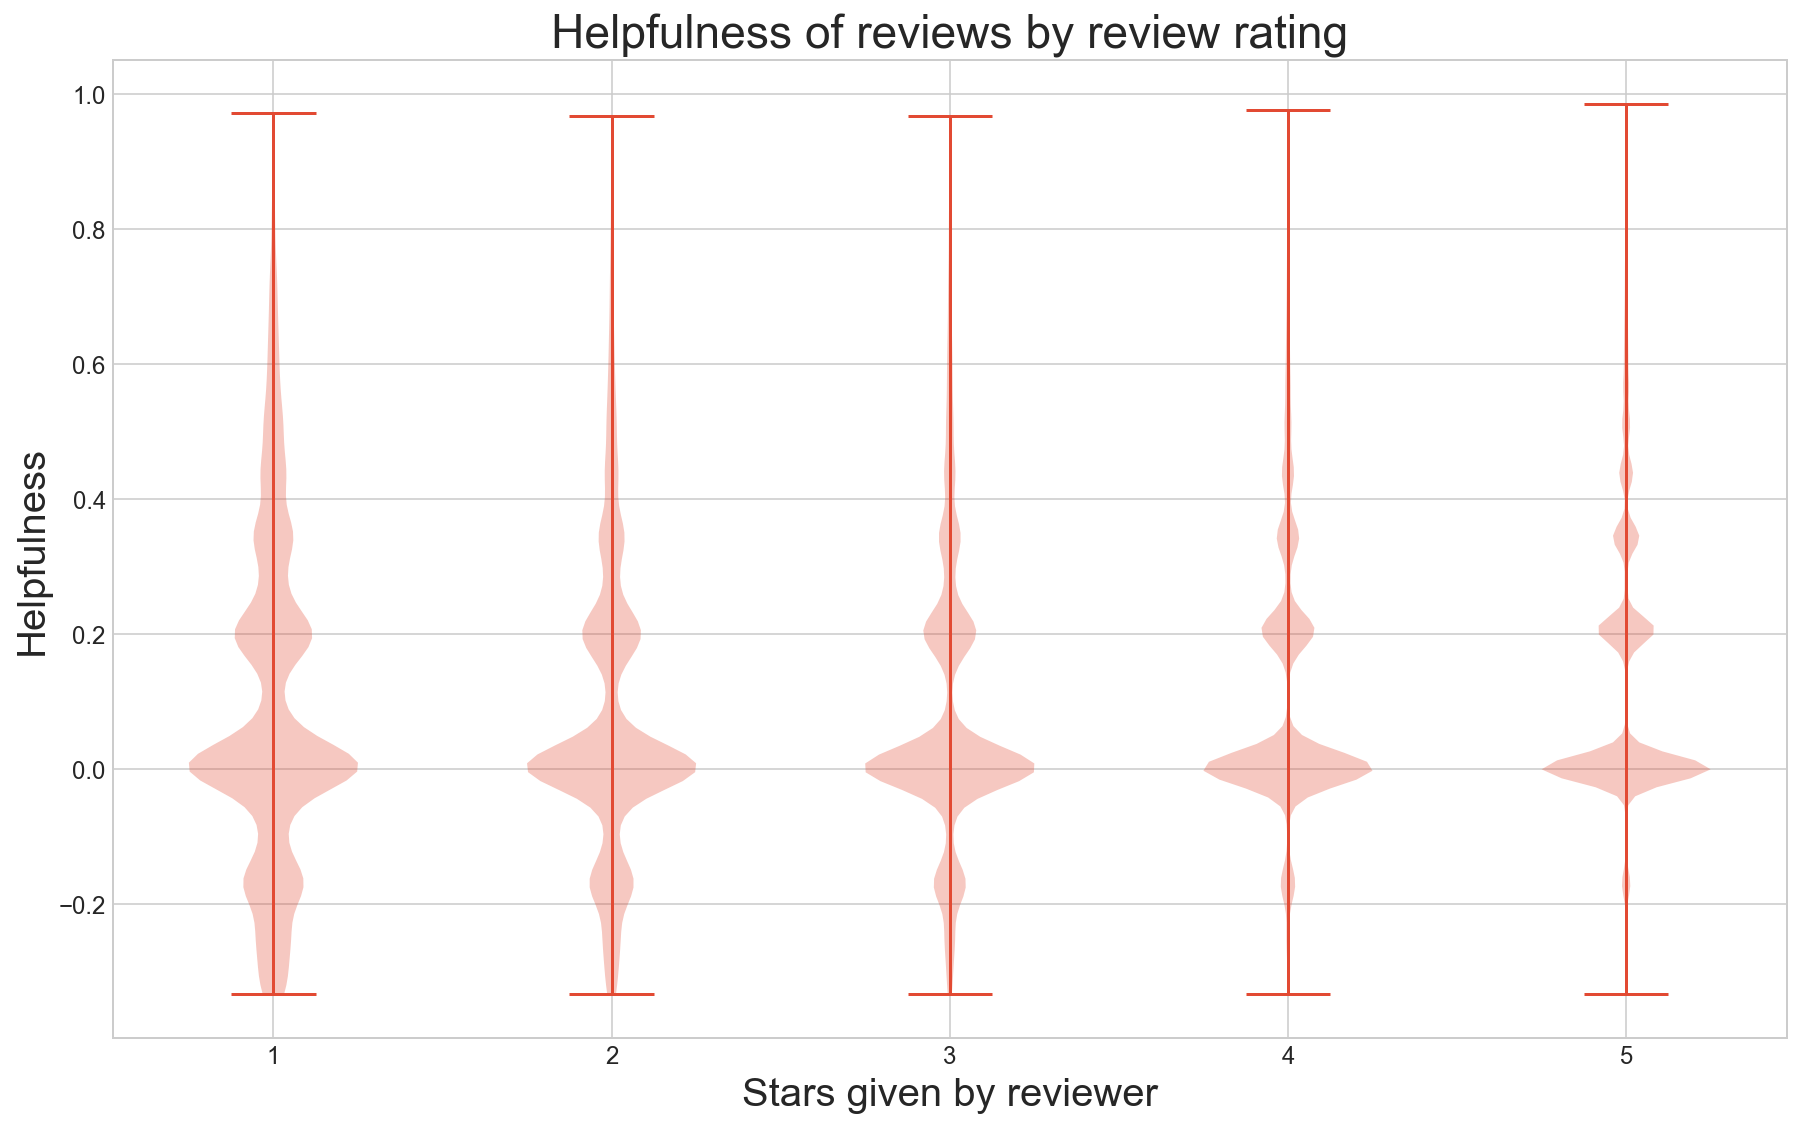

In [57]:
# Graph included entries with zero votes
# [CITE] https://stackoverflow.com/a/43346806/3592716
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=lbc_split_by_score(dfs))
axes.set_title('Helpfulness of reviews by review rating')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Stars given by reviewer')
plt.show()

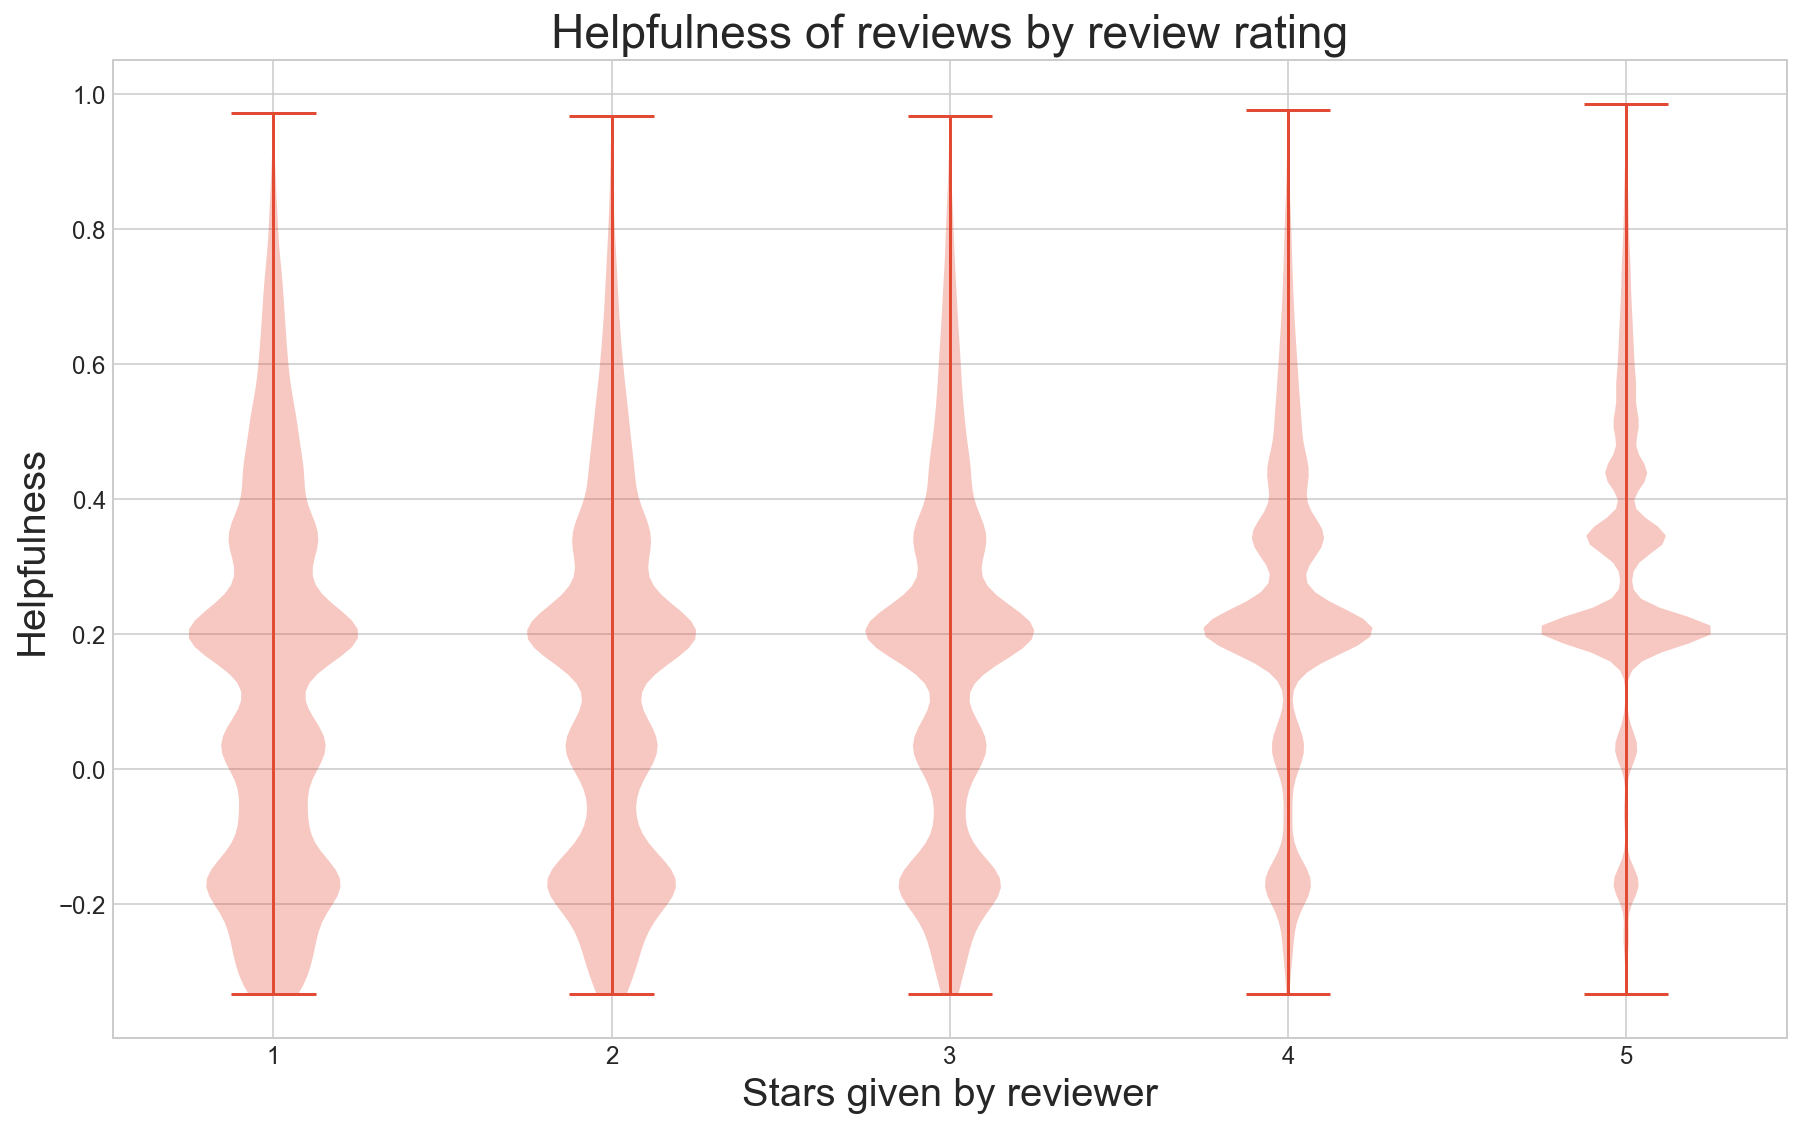

In [58]:
#As the rating the author goes up, the usefulness of the comment get better

# Graph containing only entries that have atleast 1 vote
dfs_without_zero_helpfulness = dfs[dfs['HelpfulnessDenominator'] != 0]

sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=lbc_split_by_score(dfs_without_zero_helpfulness))
axes.set_title('Helpfulness of reviews by review rating')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Stars given by reviewer')
plt.show()

In [67]:
top_x_size = 20

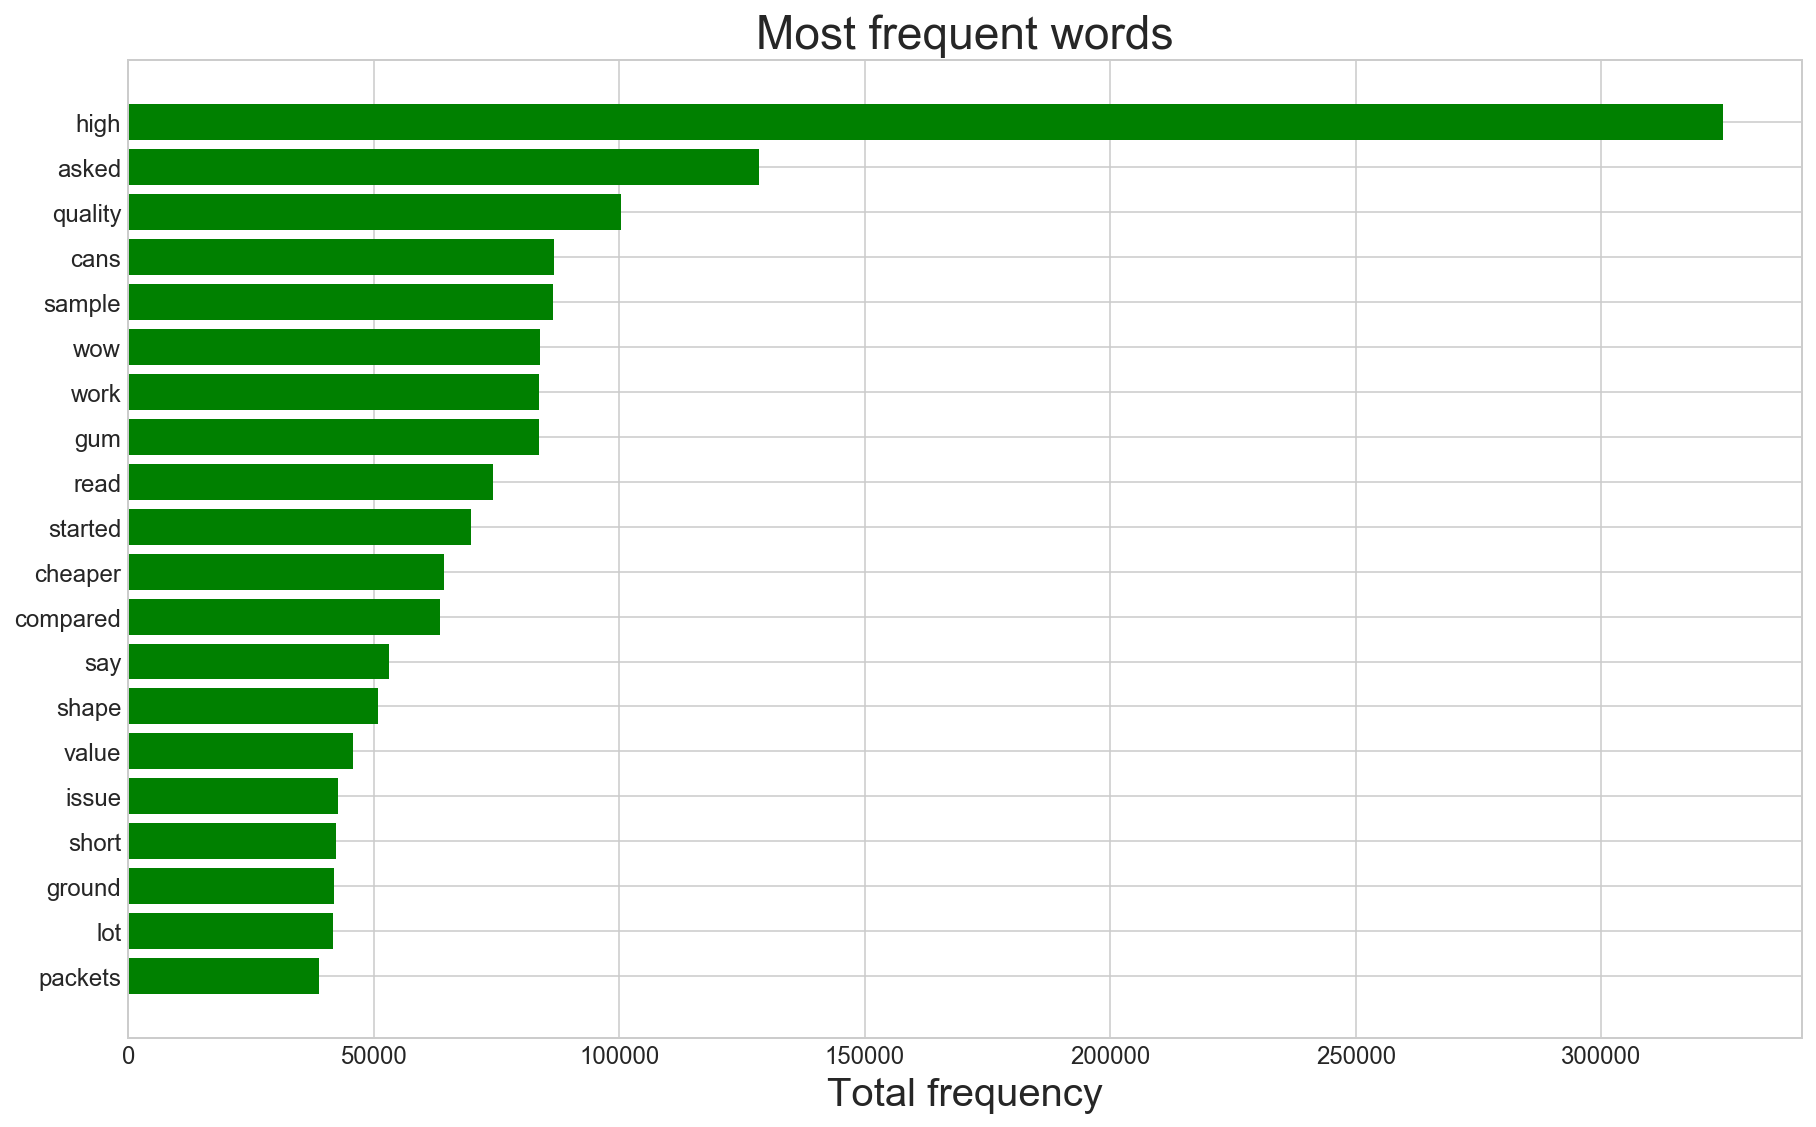

In [68]:
# total_word_frequency has already been sorted
most_frequent_words = total_word_frequency[0:top_x_size]
y_pos = np.arange(top_x_size)

fig, axes = plt.subplots()
axes.barh(y_pos, most_frequent_words, align='center', color='green')

# Most to least frequent
axes.set_yticks(y_pos)
axes.set_yticklabels(most_frequent_words.index)
axes.invert_yaxis()

axes.set_xlabel('Total frequency')

axes.set_title('Most frequent words')

plt.show()

In [69]:
# Accumulate the sum of each of the columns into
words_mean_tf_idf = df_tf_idf.mean(axis = 0).sort_values(ascending=False)

highest_tf_idf = words_mean_tf_idf[0:top_x_size]
y_pos = np.arange(top_x_size)

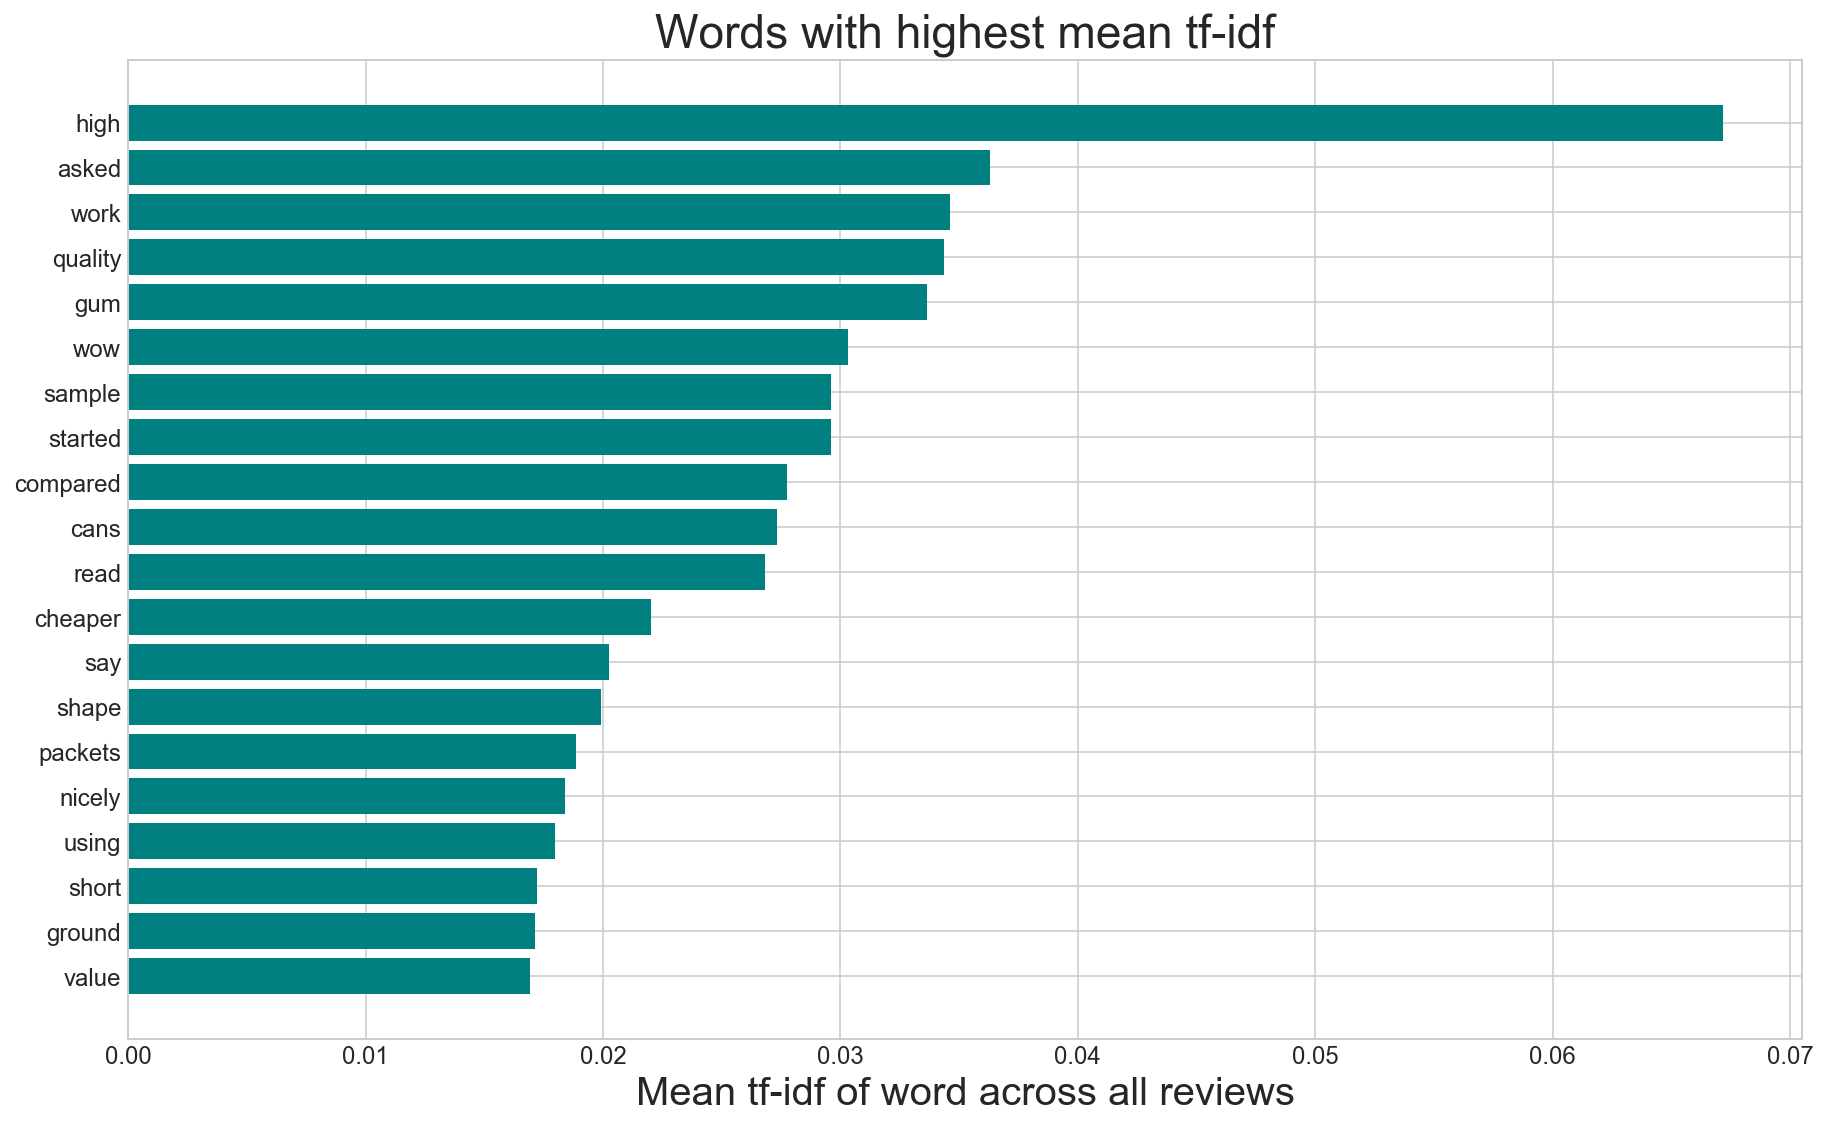

In [74]:
fig, axes = plt.subplots()

axes.barh(y_pos, highest_tf_idf, align='center', color='teal')

axes.set_yticks(y_pos)
axes.set_yticklabels(highest_tf_idf.index)
axes.invert_yaxis()  # labels read top-to-bottom

axes.set_xlabel('Mean tf-idf of word across all reviews')

axes.set_title('Words with highest mean tf-idf')

plt.show()

In [76]:
lowest_tf_idf = words_mean_tf_idf[-1*top_x_size:]
y_pos = np.arange(top_x_size)

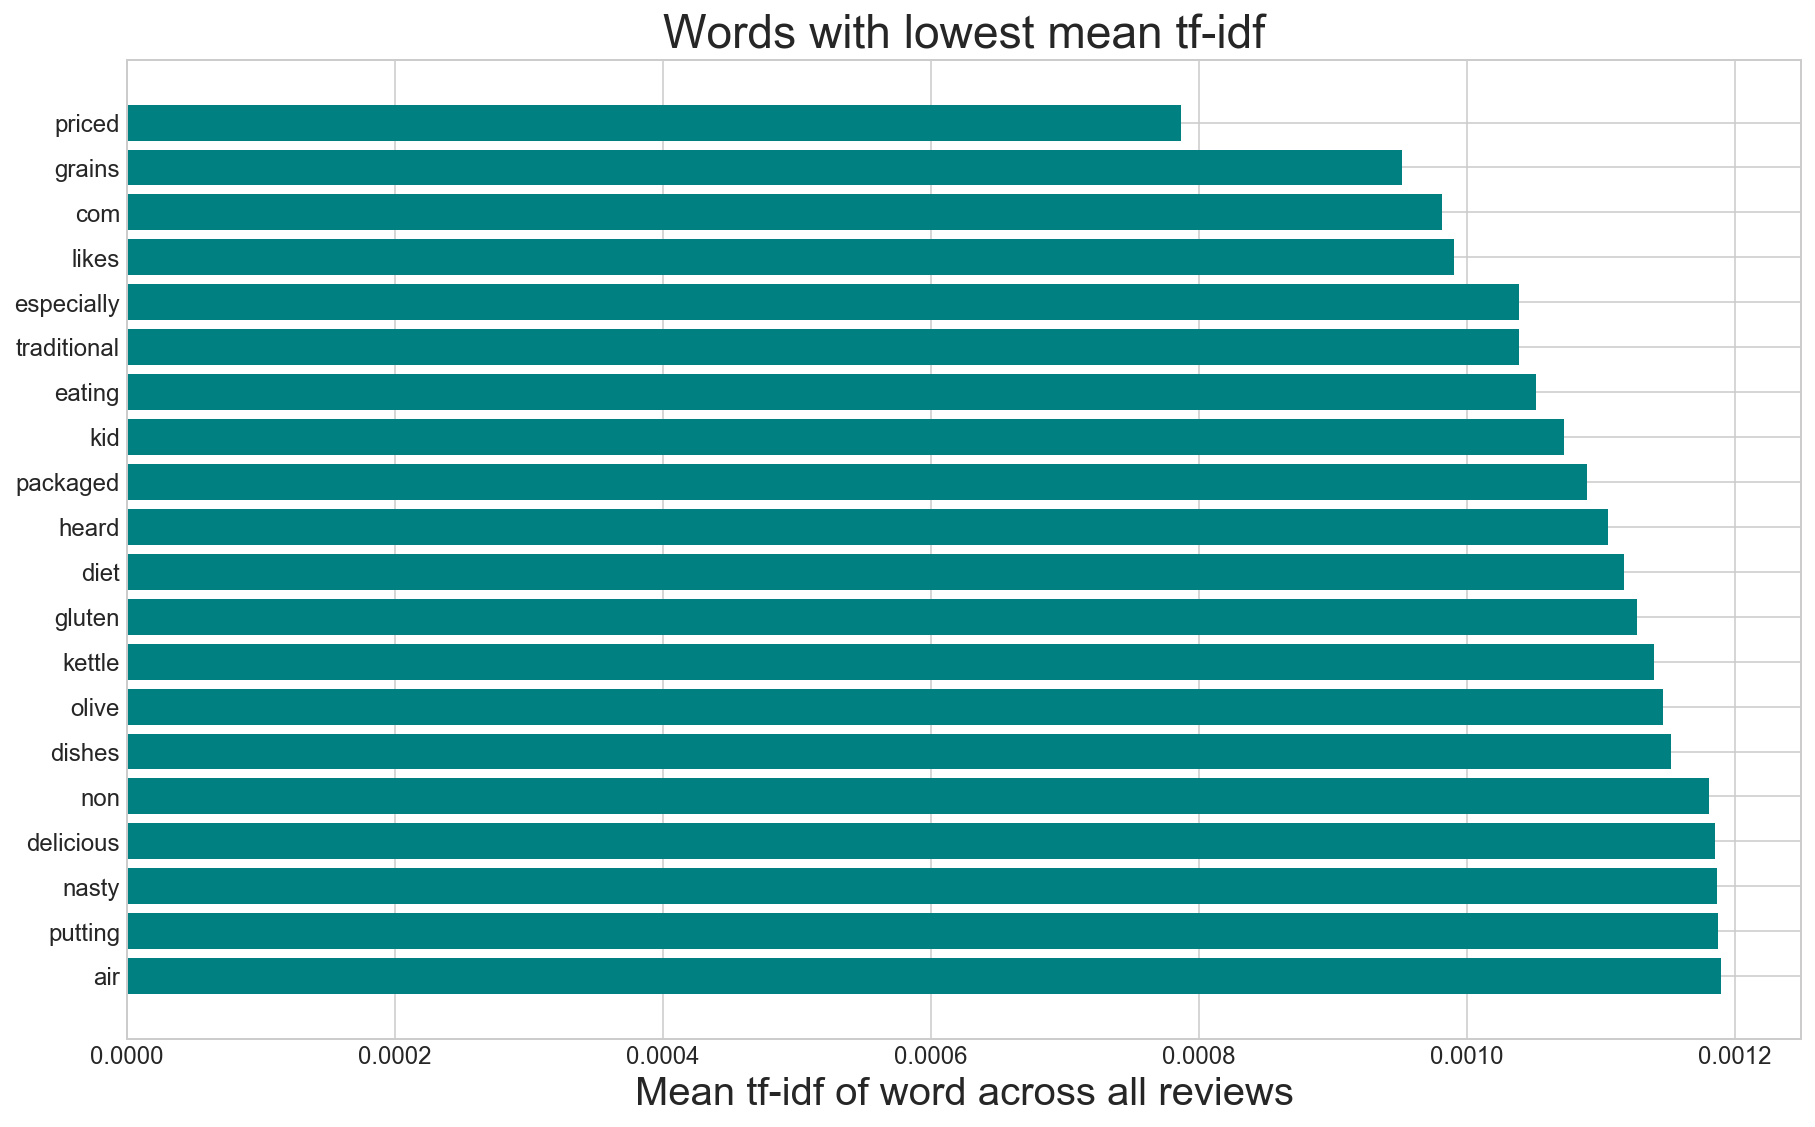

In [77]:
fig, axes = plt.subplots()

axes.barh(y_pos, lowest_tf_idf, align='center', color='teal')
axes.set_yticks(y_pos)
axes.set_yticklabels(lowest_tf_idf.index)
axes.set_xlabel('Mean tf-idf of word across all reviews')

axes.set_title('Words with lowest mean tf-idf')

plt.show()

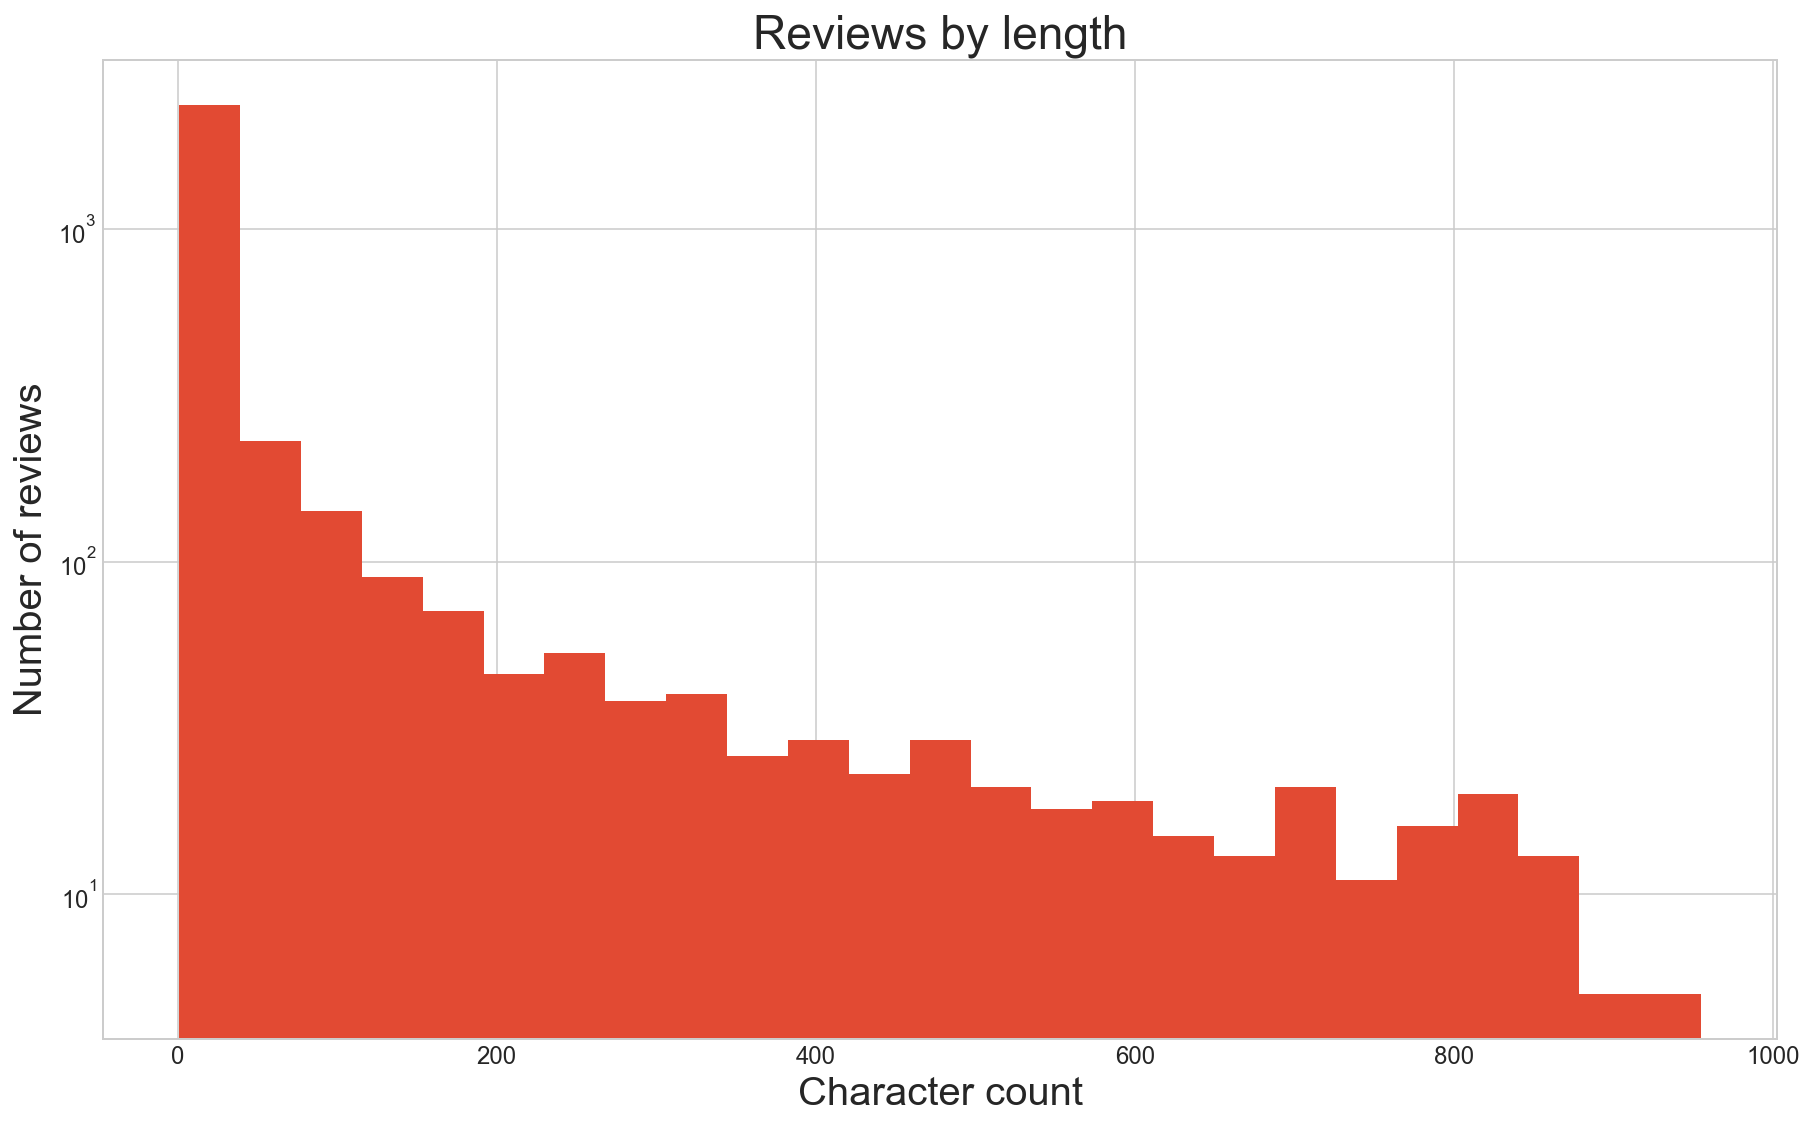

In [78]:
plt.hist(dfs['ReviewLength'].value_counts(), bins=25)
plt.yscale('log')
plt.title('Reviews by length')
plt.ylabel('Number of reviews')
plt.xlabel('Character count')
plt.show()

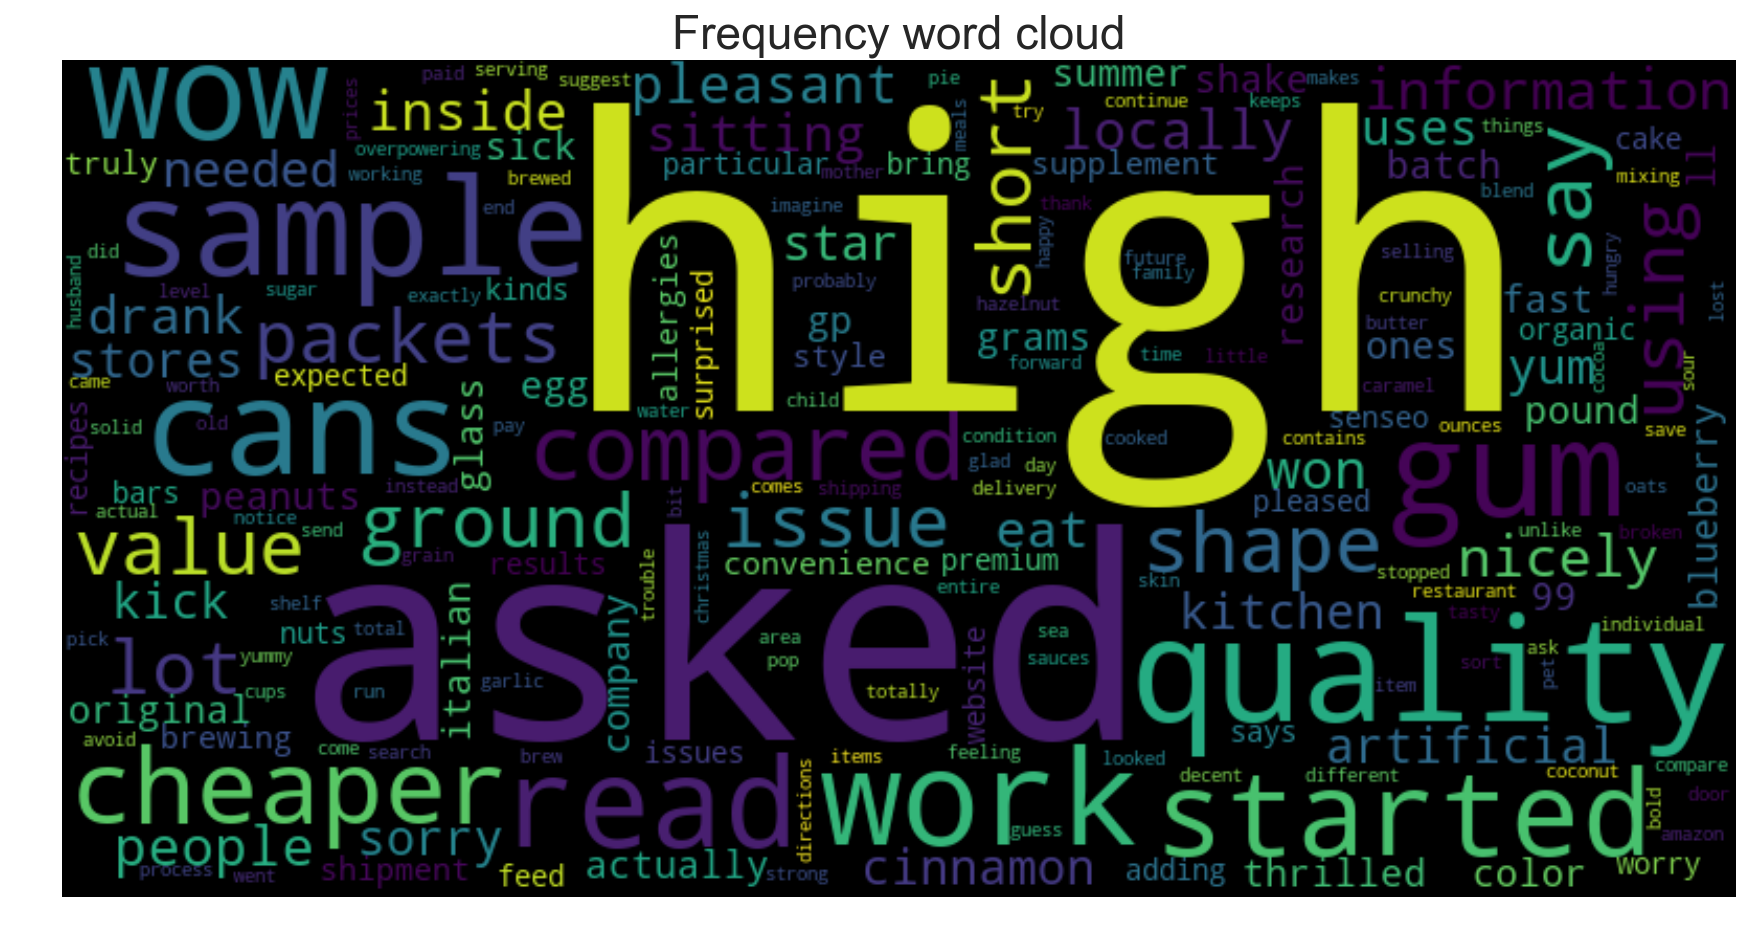

In [82]:
wc = WordCloud(background_color='black',width=800, height=400).generate_from_frequencies(total_word_frequency)
plt.imshow(wc, interpolation='bilinear')
plt.title('Frequency word cloud')
plt.axis("off")
plt.show()

In [83]:
# Full dataset (reviews) grouped by star rating
dfs_split_by_score = {score: dfs[dfs['Score'] == score] for score in range(1,6)}

In [120]:
# Columns are words, rows are reviews, cells are occurrence counts - grouped by star rating
def calculate_word_frequency(field):
    return pd.DataFrame(
        vectorizer.fit_transform(field).toarray(),
        columns=vectorizer.vocabulary_.keys(),
        dtype='int16'
    )

bag_of_words_by_score = {score: calculate_word_frequency(dfs_split_by_score[score]['Text']) for score in range(1,6)}
total_word_frequency_by_score = {key: value.sum(axis=0) for (key, value) in bag_of_words_by_score.items()}

In [121]:
# Columns are words, rows are reviews, cells are word Tf-idf scores - grouped by star rating
def calculate_tf_idf(field):
    return pd.DataFrame(
        tf_idf_vectorizer.fit_transform(field).toarray(),
        columns=tf_idf_vectorizer.vocabulary_.keys(),
        dtype='float32'
    )

tf_idf_split_by_score = {score: calculate_tf_idf(dfs_split_by_score[score]['Text']) for score in range(1,6)}

In [102]:
mean_and_sort = lambda f: f.mean(axis=0).sort_values(ascending=False)
words_mean_tf_idf_split_by_score = {key: mean_and_sort(value) for (key, value) in tf_idf_split_by_score.items()}

In [144]:
def highest_mean_tf_idf_for_score(score):
    words_highest_mean_tf_idf_for_score = words_mean_tf_idf_split_by_score[score][0:top_x_size]
    y_pos = np.arange(top_x_size)
    
    fig, axes = plt.subplots()
    axes.barh(y_pos, words_highest_mean_tf_idf_for_score, align='center', color='teal')
    
    axes.set_yticks(y_pos)
    axes.set_yticklabels(words_highest_mean_tf_idf_for_score.index)
    axes.invert_yaxis()
    
    axes.set_xlabel(f'Mean tf-idf of word for all {score}-star reviews')
    axes.set_title(f'Words with highest mean tf-idf among {score}-star reviews')
    plt.show()

def word_cloud_for_score(score):
    masks = {score: f'img/{score}.jpg' for score in range(1,6)}
    cloud_mask = np.array(Image.open(masks[score]))
    wc = WordCloud(mask=cloud_mask)
    wc = wc.generate_from_frequencies(total_word_frequency_by_score[score])
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Frequency word cloud among {score}-star reviews')
    plt.axis('off')
    plt.show()

def target_class_words_summary(score):
    highest_mean_tf_idf_for_score(score)
    word_cloud_for_score(score)

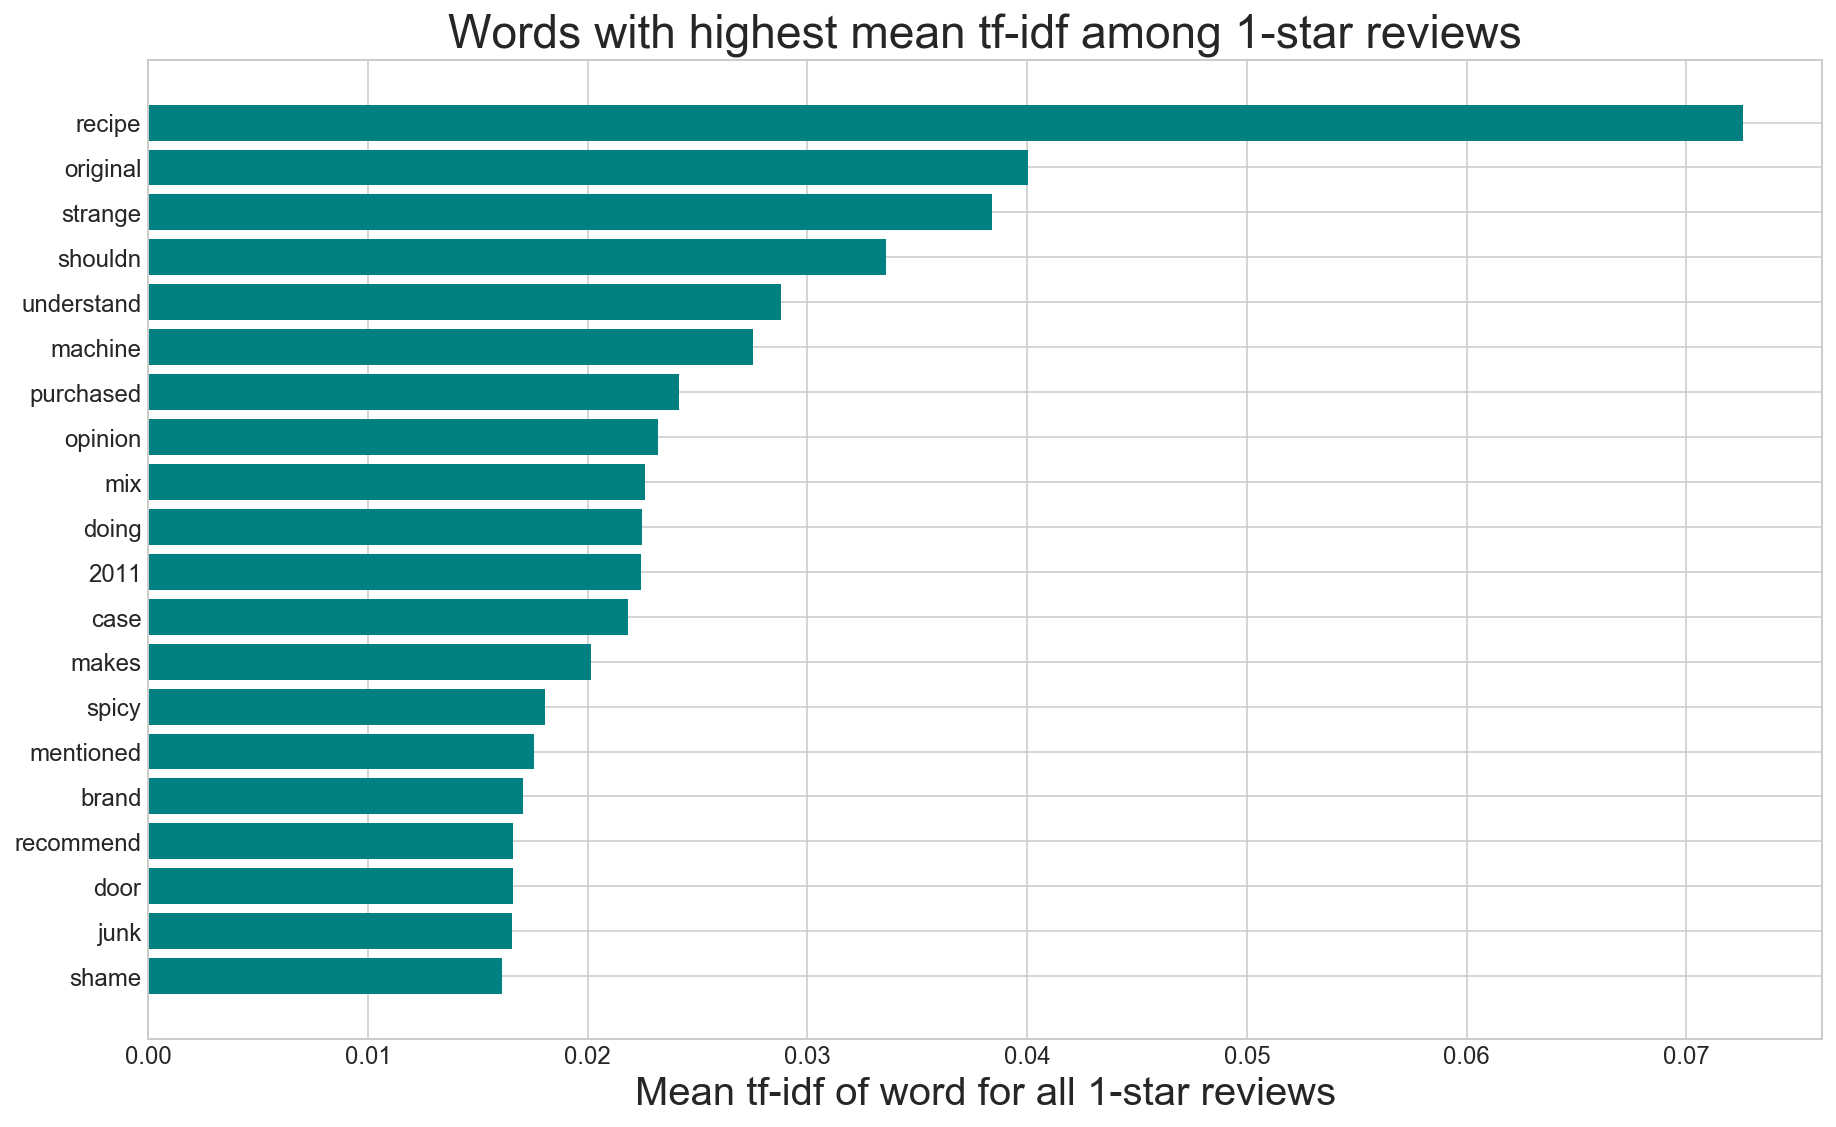

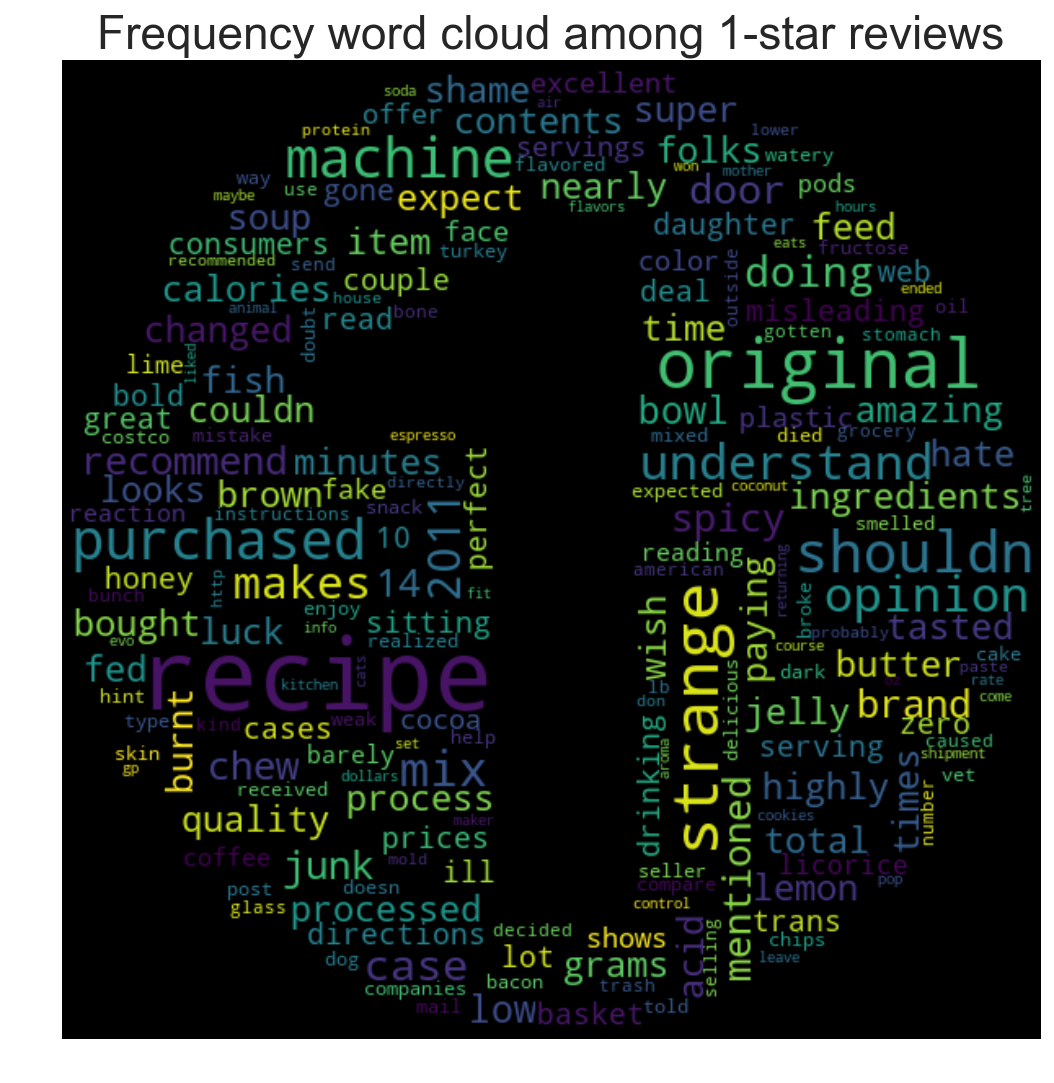

In [145]:
target_class_words_summary(1)

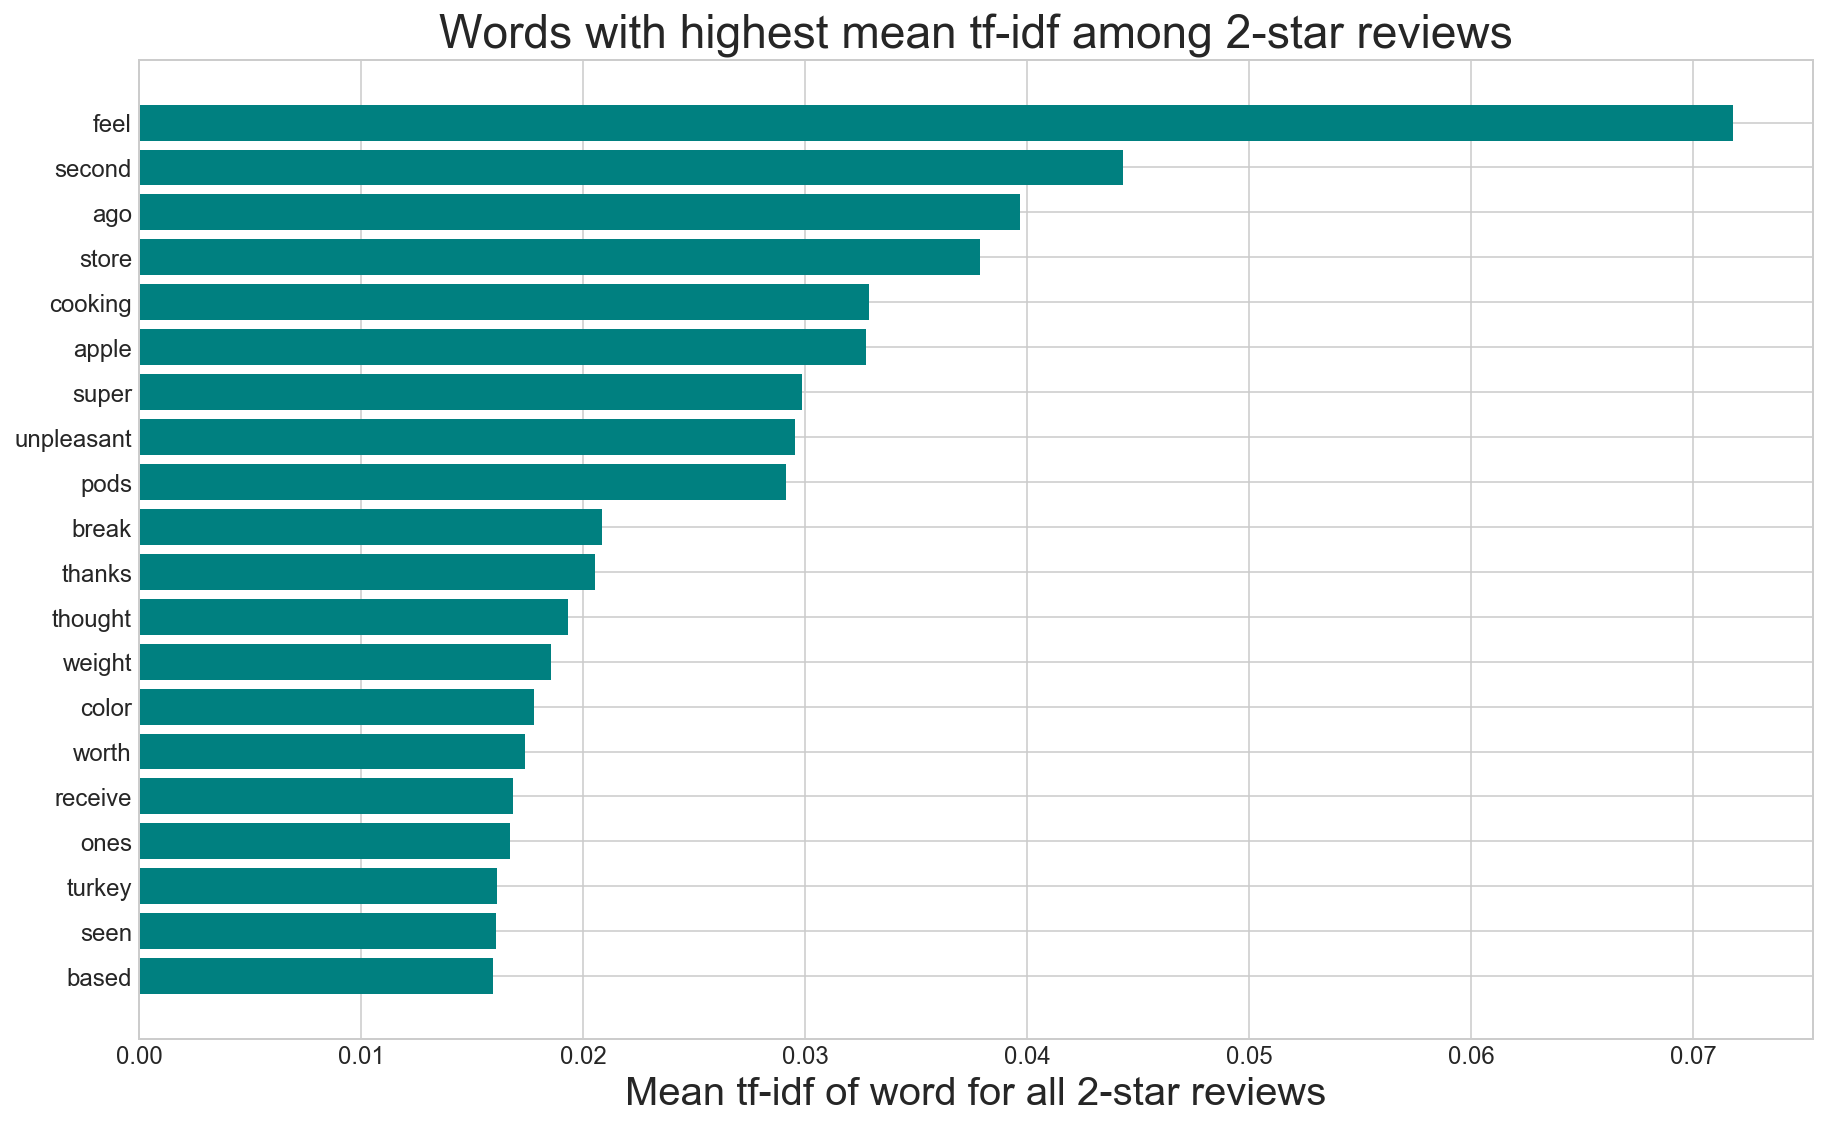

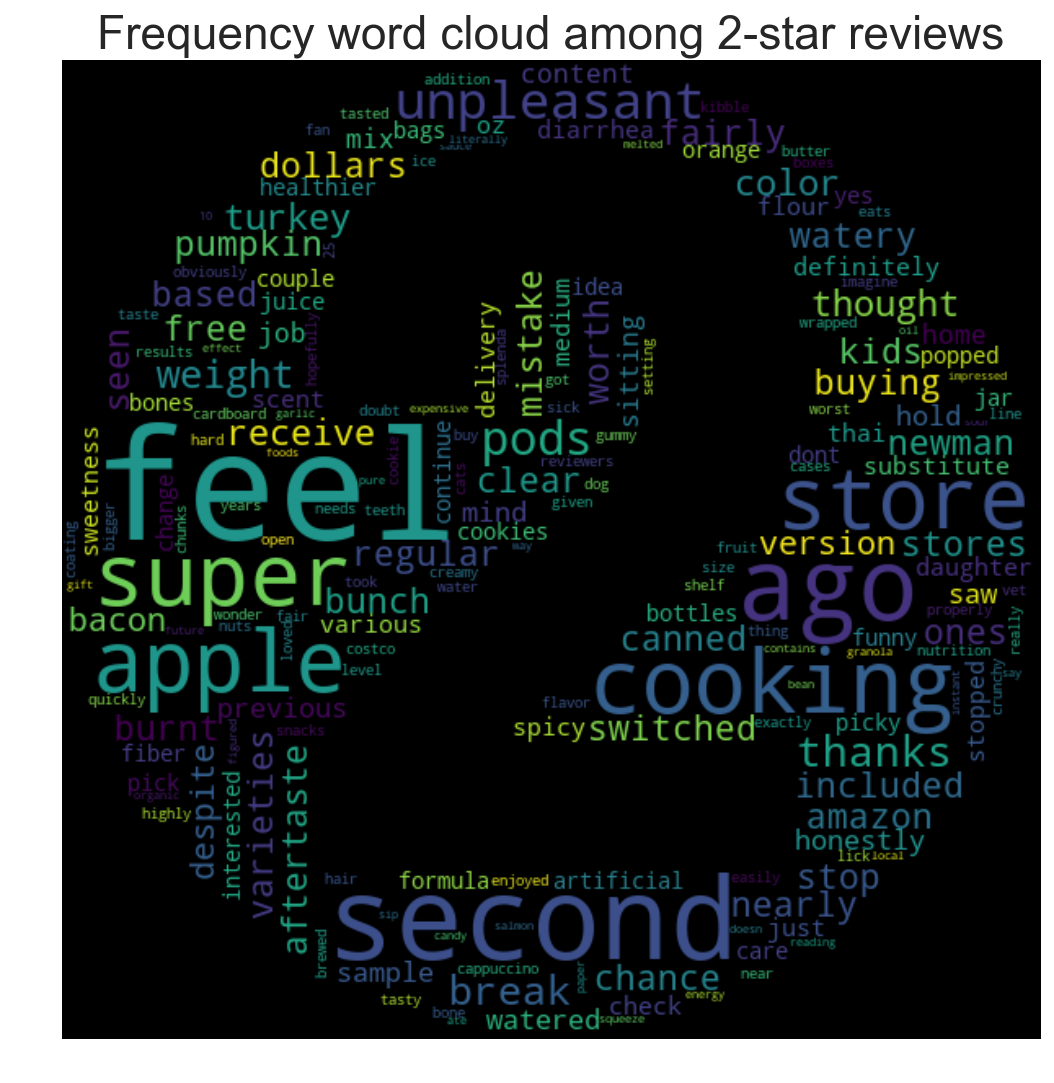

In [146]:
target_class_words_summary(2)

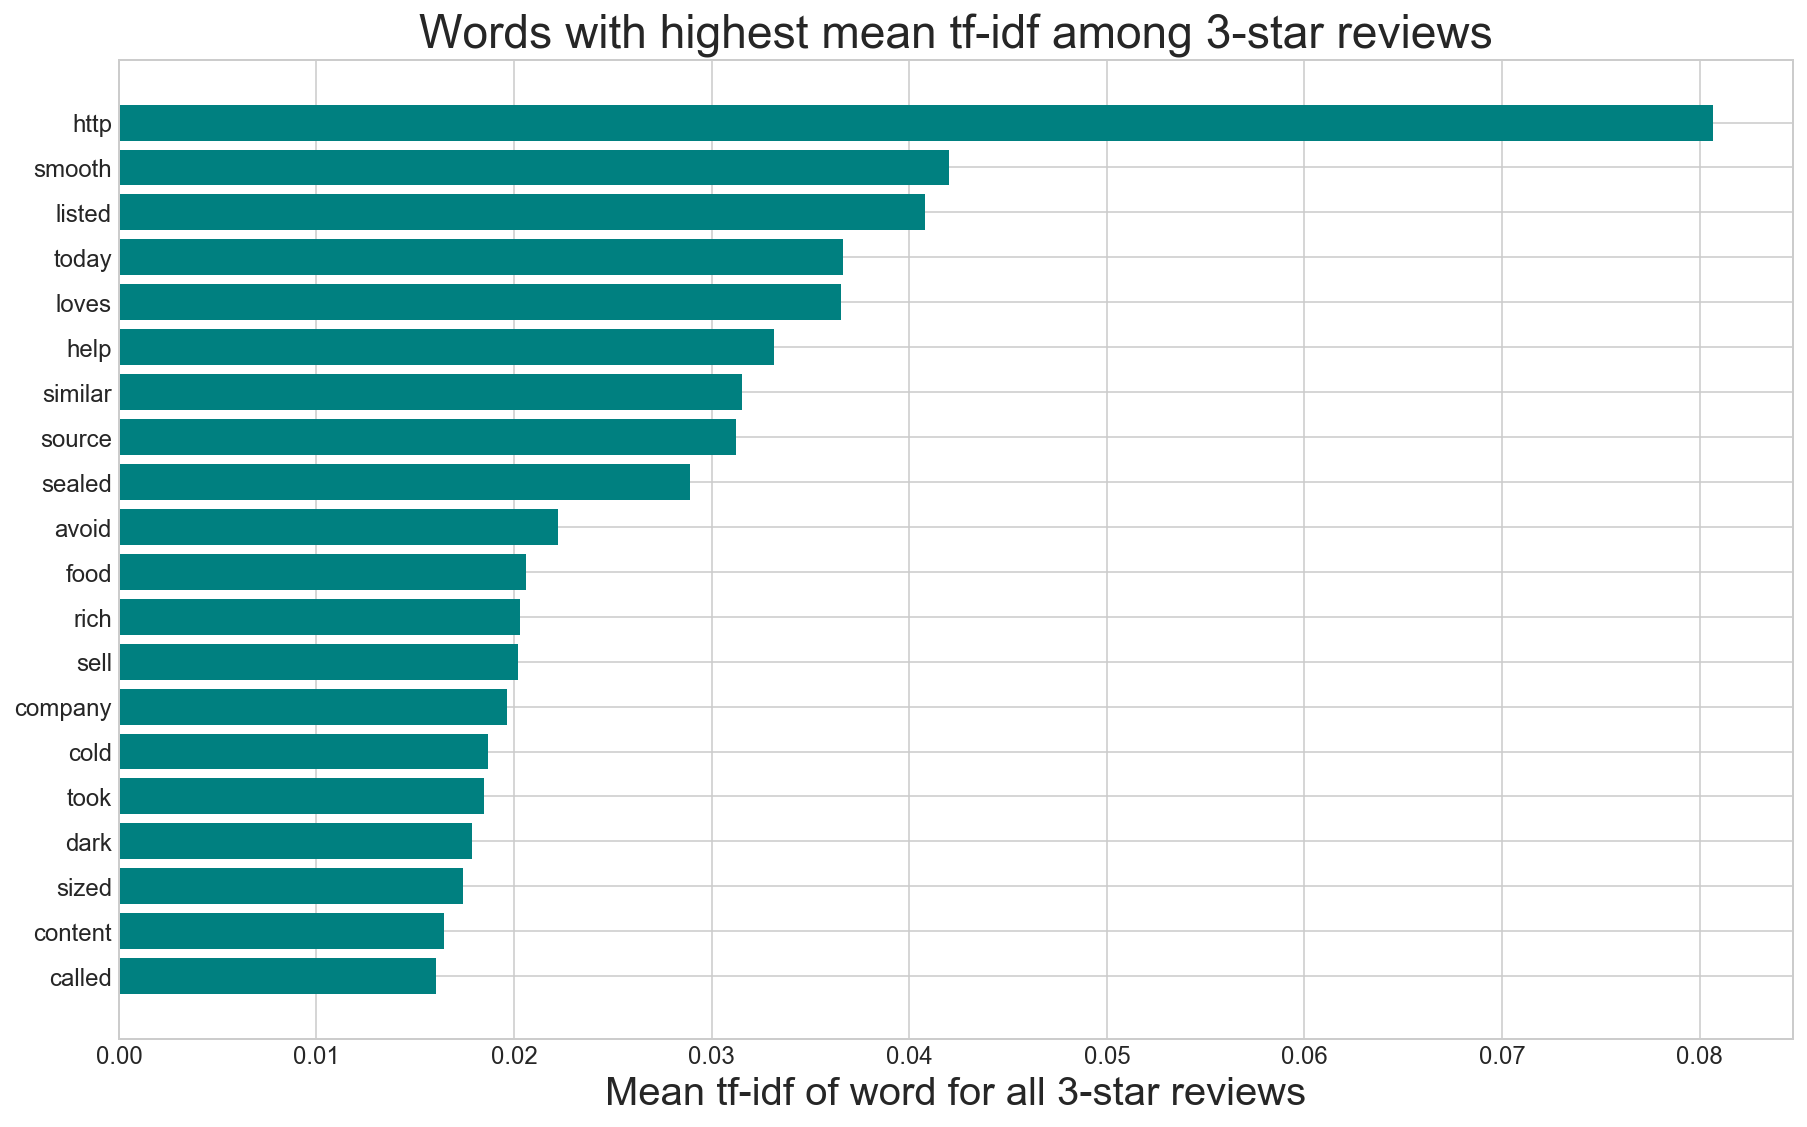

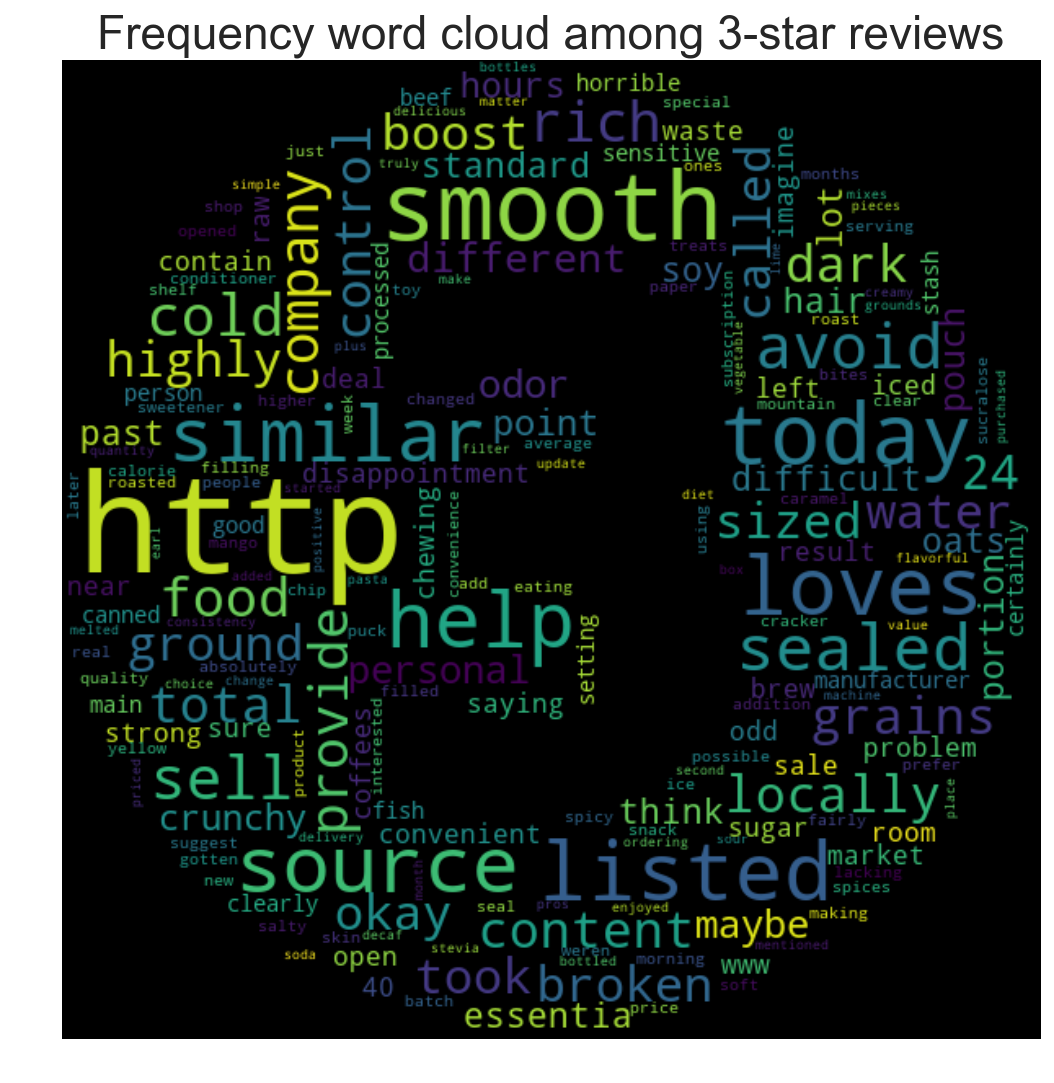

In [147]:
target_class_words_summary(3)

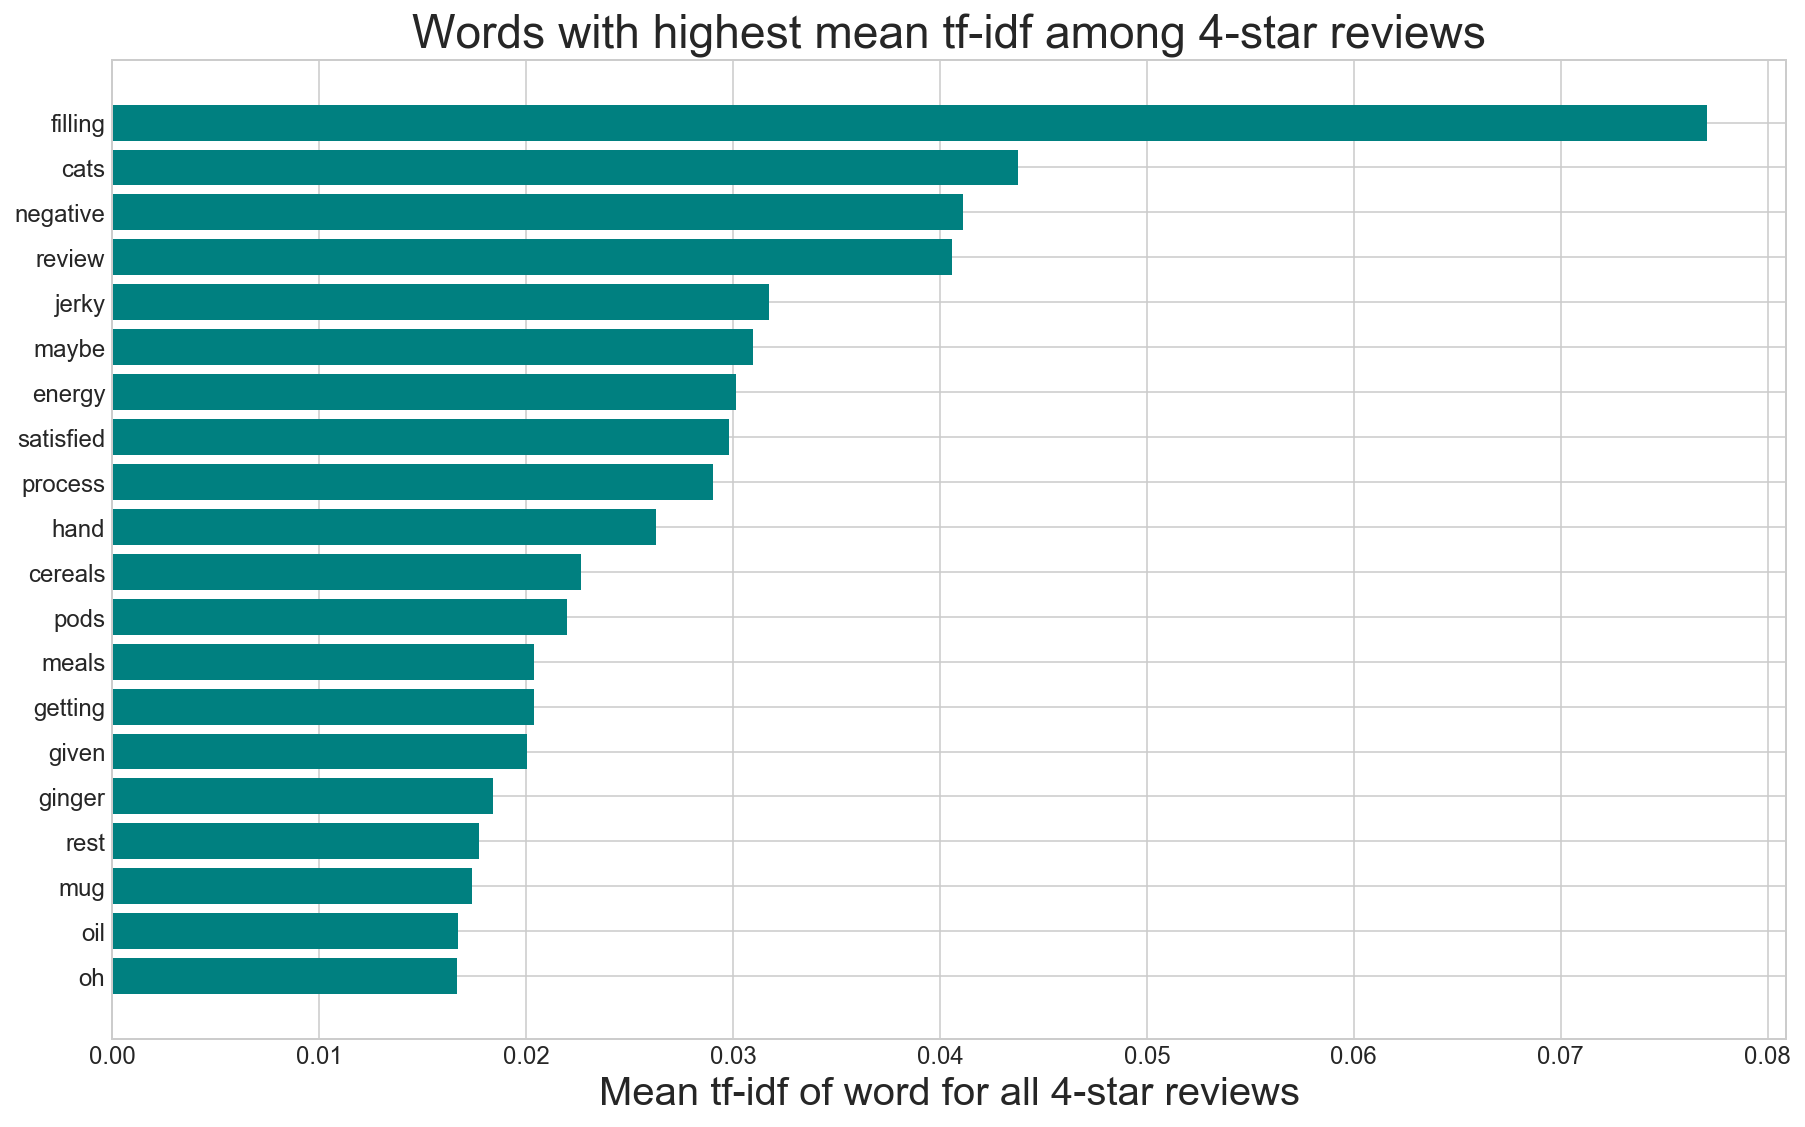

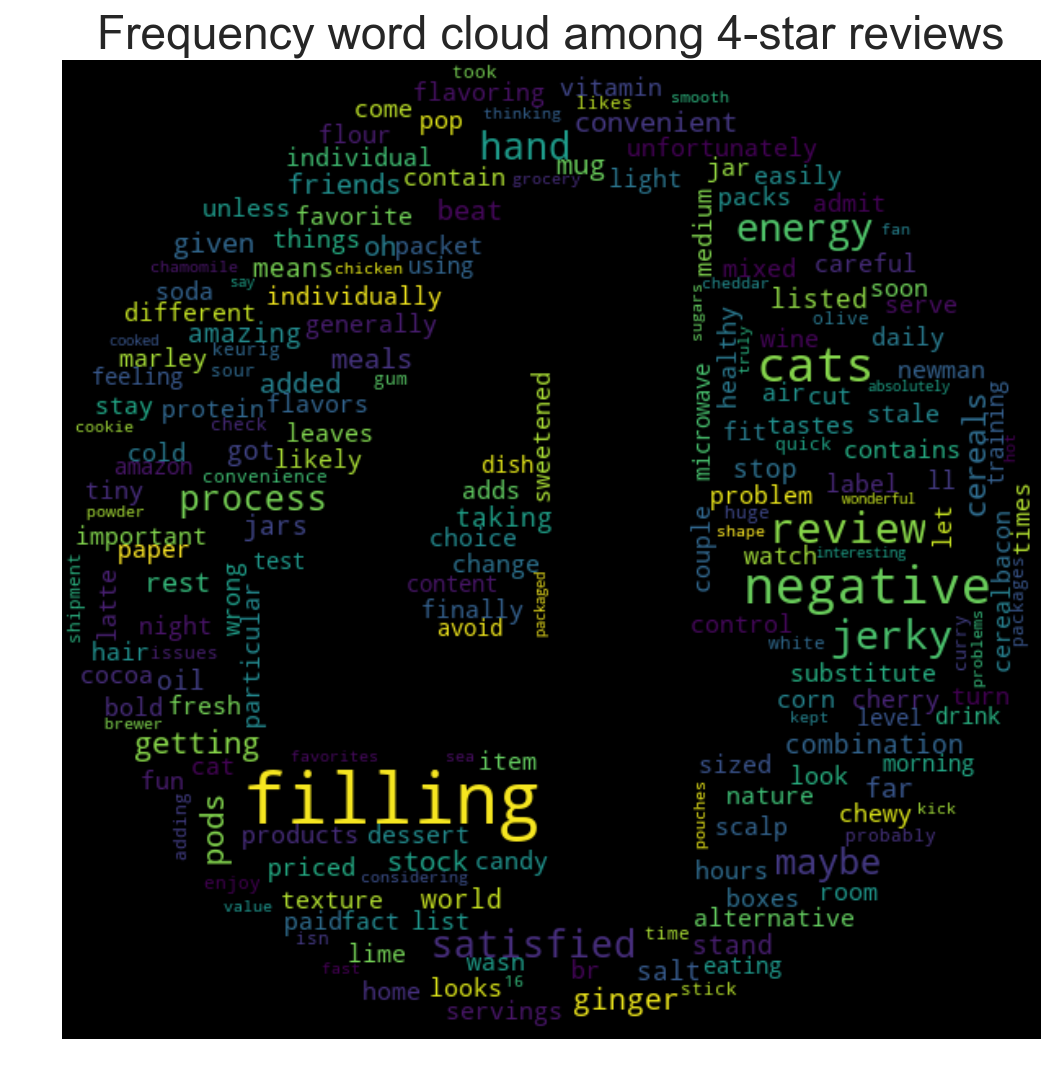

In [148]:
target_class_words_summary(4)

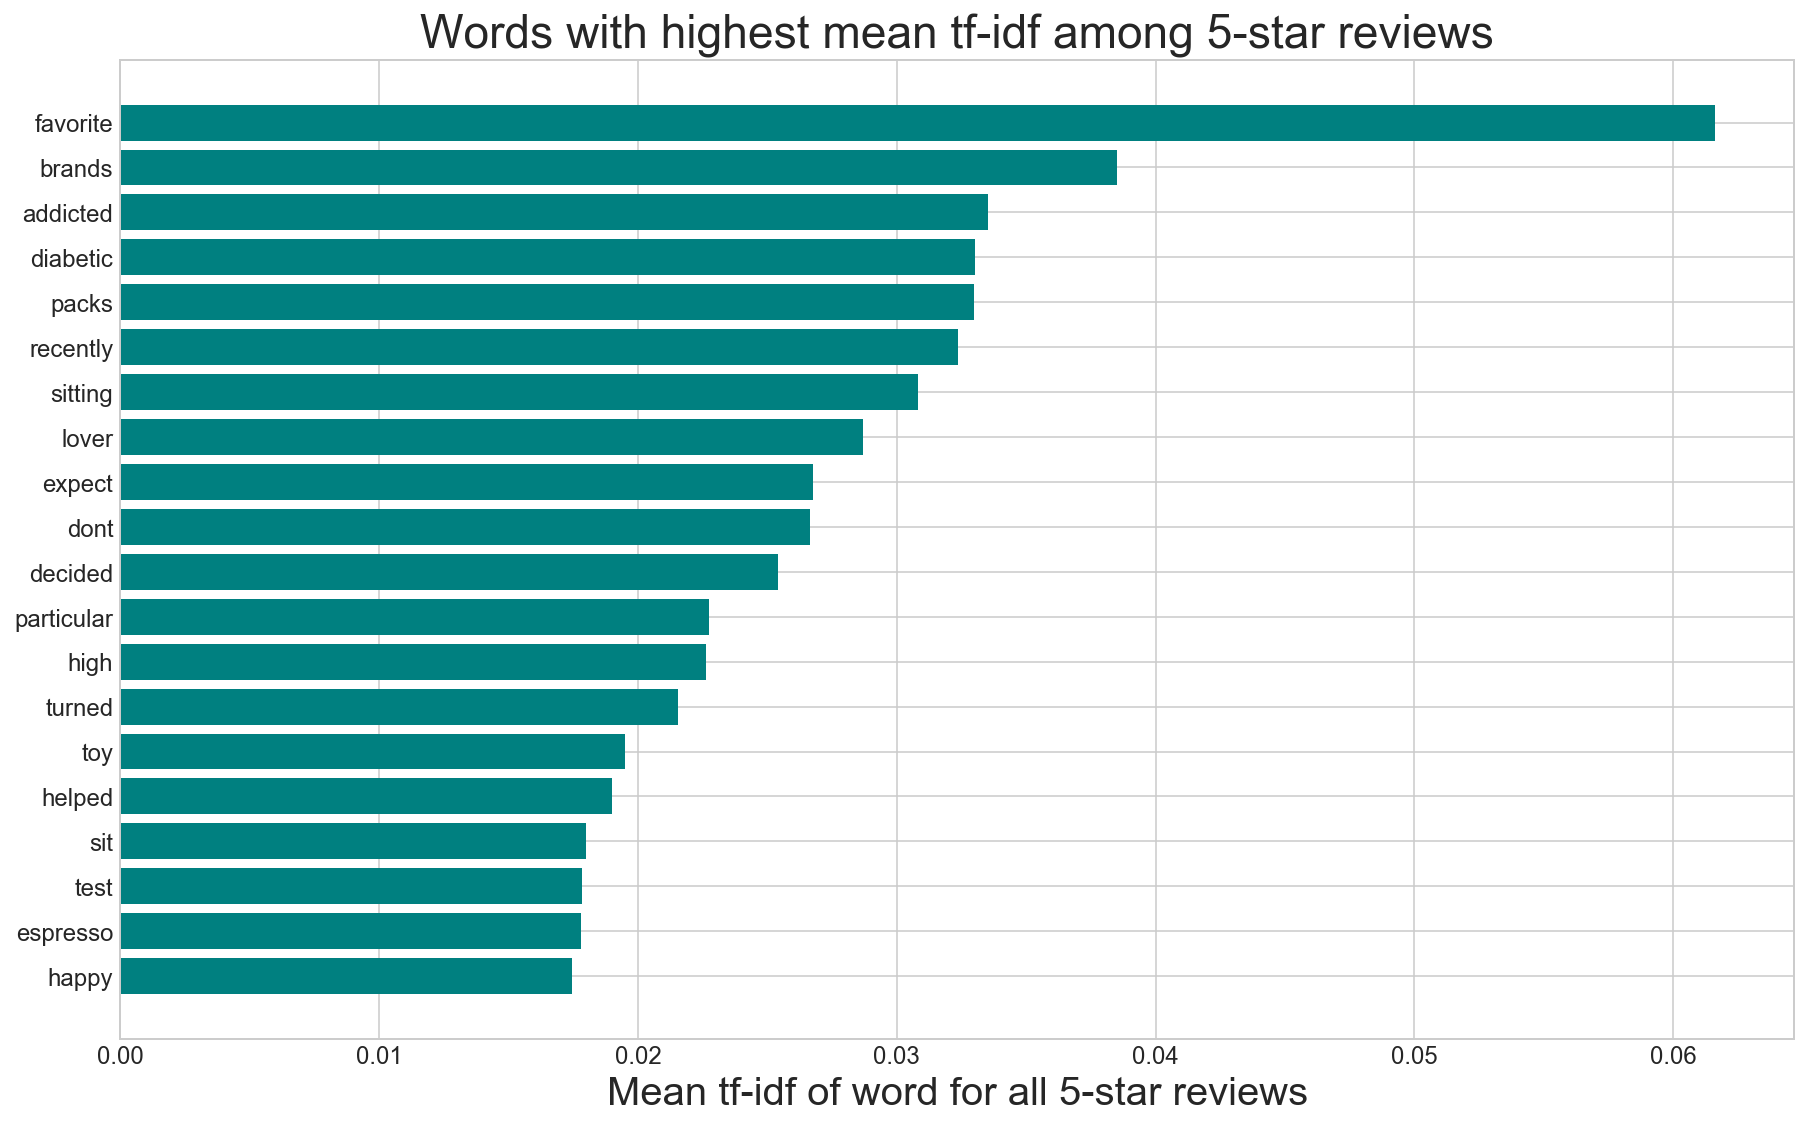

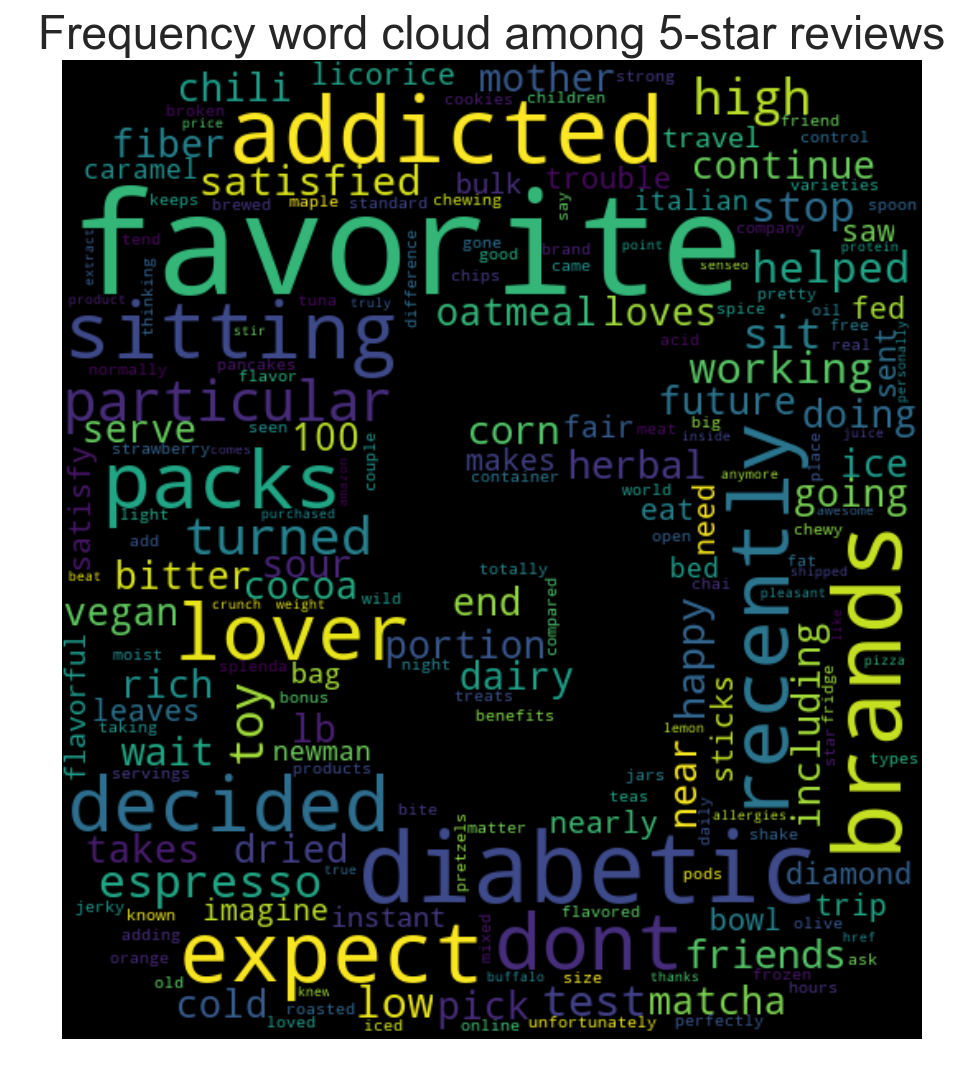

In [149]:
target_class_words_summary(5)